# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JohnsonUtil import johnson_cons as ct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
# code_list = sina_data.Sina().all.index.tolist()
# print(f'code_list:{len(code_list)}')
# df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')

In [3]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [4]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [5]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(9.66, '2025-06-19')

(10.7,
 59    2025-09-10
 Name: date, dtype: object)

9 -0.12 -1.08
Bear
-1.08


### regression_line(X, Y)
regression_ratio(df, window=10):

9.96 0.02
Above
0.02


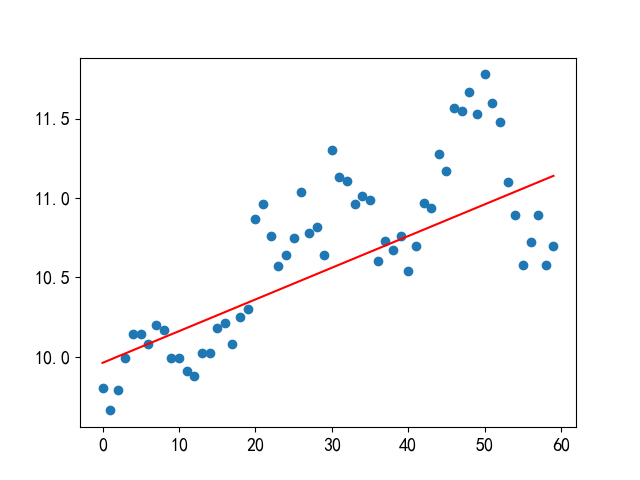

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

9.96 0.02
Above
0.02


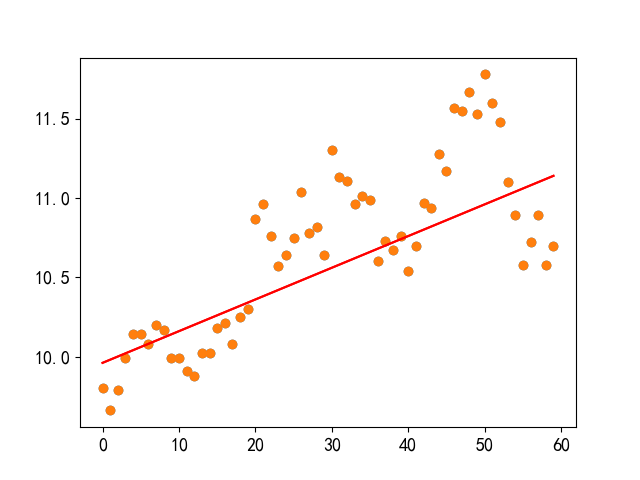

In [7]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [8]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max5', 'max10', 'hmax', 'hmax60', 'high4', 'llowvol', 'low10', 'low60',
       'low4', 'lastdu4'],
      dtype='object', length=175)

### check_postion_vol_price

In [9]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code   open   high    low  close         vol       amount  \
59  2025-09-10  601360  10.59  10.85  10.56   10.7  90584812.0  970190912.0   

    lower   ene  ...  max10   hmax  hmax60  high4     llowvol  low10  low60  \
59   10.3  11.1  ...  11.78  11.78   11.04  10.89  82503528.0  10.58   9.66   

     low4  lastdu4  Positon  
59  10.41      2.7  Neutral  

[1 rows x 176 columns]

In [10]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max10', 'hmax', 'hmax60', 'high4', 'llowvol', 'low10', 'low60', 'low4',
       'lastdu4', 'Positon'],
      dtype='object', length=176)

0    2025-06-19
1    2025-06-20
2    2025-06-23
Name: date, dtype: object

59   2025-09-10
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.02 
code: 601360


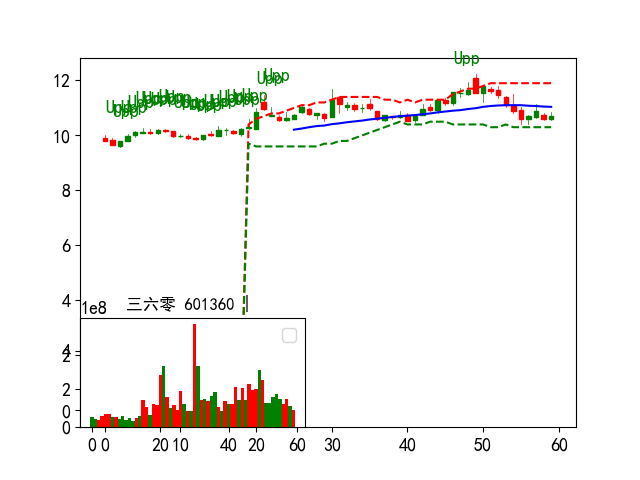

In [11]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [12]:
'code' in dfc.columns

True

### show_channel_mpl

In [13]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)
    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [14]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None,limit=20,orderby='percent'):
    col_src = [
        "name",'percent', "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]
    if df is None:
        print('df is None')
        return df
    if 'close' in df.columns:
        df = df.query('close > 0')
    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if orderby in df.columns:
        df=df.sort_values('percent', ascending=False)
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name][:limit]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name][:limit]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name][:limit]
    return temp

def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [15]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.3,
        ma_250_h=1.3, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().all.index.tolist()
#     .Sina().all.index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    print(f'h5_fname:{h5_fname} h5_table:{h5_table}')
#     df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20170501', end=None, freq=None, col=None, index='date')
#     df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
#         freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)
    print(f'df:{df}')
    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [16]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.2,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5200
h5_fname:tdx_all_df_300 h5_table:all_300
df:                      open     high      low    close          vol  \
code   date                                                          
999999 2023-11-02  3028.00  3038.00  3010.00  3010.00  268794592.0   
       2023-11-03  3012.00  3040.00  3012.00  3030.00  268486336.0   
       2023-11-06  3048.00  3058.00  3038.00  3058.00  372949632.0   
       2023-11-07  3052.00  3064.00  3042.00  3058.00  326853440.0   
       2023-11-08  3052.00  3062.00  3038.00  3052.00  335677824.0   
...                    ...      ...      ...      ...          ...   
301231 2025-09-10    24.73    25.44    24.73    25.12    2178516.0   
300014 2025-09-10    70.00    71.31    69.00    70.12  109163168.0   
300237 2025-09-10     3.35     3.50     3.30     3.36  166545584.0   
300033 2025-09-10   345.00   358.25   345.00   351.50    9457915.0   
300858 2025-09-10    18.91    19.42    18.50    19.20    9218239.0   

                         amoun

In [17]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close          vol       amount
date                                                         
2025-09-10  6.81  6.86  6.76   6.86  139719680.0  950570496.0

### Test InStock

In [18]:
df.loc['301083'][:2]

open   high    low  close        vol       amount
date                                                          
2023-11-02  15.78  16.22  15.50  15.50  1845500.0   29343732.0
2023-11-03  15.86  17.83  15.73  16.91  9484947.0  160420160.0

## ra_diff

In [19]:
tail_days = 60

In [20]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [21]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [22]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [23]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [24]:
# df.loc['000002'][-10:]

## sina_dm

In [25]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2025-09-10',
 code
 301285    鸿日达
 Name: name, dtype: object)

In [26]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-09/10/25 20:58:17'

code
688178   2025-09-10 15:00:03
600418   2025-09-10 15:00:03
Name: ticktime, dtype: datetime64[ns]

358.24007470607756

### Combine ratio and idx

In [27]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [28]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if len(store.keys()) > 0 and root is None and store is not None:
        root = store.keys()[0].replace("/", "")
        df = store[root]
        df = apply_col_toint(df)
    else:
        df = None
    store.close()
    return df

In [29]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = f"{cct.get_ramdisk_dir()}\\sina_MultiIndex_data.h5".replace('\\',os.sep)
print(f'sina_MultiD_path:{sina_MultiD_path}')
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
if h5 is not None:
    h5.shape
    h5code='603019'
    h5.loc[h5code][-3:]
    code_muti = '603019'
    # h5.loc[code_muti][:2]

    freq = 'D'
    # freq = '5M'
    startime = '09:25:00'
    endtime = '15:01:00'

    time_ratio = cct.get_work_time_ratio()
    time_ratio
    run_col = ['close', 'volume']
    # run_col = ['close']
    mdf = cct.get_limit_multiIndex_freq(
        h5, freq=freq.upper(),
        col=run_col, start=startime, end=endtime, code=None)
    allvol = mdf.volume.sum()
    allvol = round(allvol / 10 / 1000 / 1000,2)
    print("总量:%s 亿"%(allvol))
    mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
    mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
    #全局占比
    mdf['volume'] = mdf.amount.apply(
        lambda x: round(x / allvol * 100 / time_ratio, 2))
    mdf=mdf.reset_index().set_index('code')
    mdf.loc[h5code]
else:
    mdf = None

sina_MultiD_path:G:\sina_MultiIndex_data.h5
[]
G:\sina_MultiIndex_data.h5


In [30]:
if mdf is not None:
    mdf[:2]
    mdf.loc['603019']

In [31]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
if h5 is not None:
    str(h5.index.get_level_values(1)[-1])[:10]

In [32]:
if mdf is not None and len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

mdf is None


###  实时成交量个股Top!!!  (重点)

In [33]:
if mdf is not None and len(mdf) > 0:
    nowdf = mdf.sort_values(by=['volume'], ascending=[0])
    # nowdf.shape, df.shape, code_idx.shape
    # top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd=get_sina_data_cname(top20_nd)
    # nowdf.shape,top20_nd
else:
    top20_nd = None

In [34]:
# top20_nd

In [35]:
show_tdx_data(top20_nd)
# top20_nd.columns

df is None


### 合并实时成交量及SinaDM

In [36]:
from JSONData import tdx_hdf5_api as h5a
def get_tdx_all_from_h5(resample='d',showtable=True):
    #sina_monitor
    # h5_fname = 'tdx_last_df'
    # resample=resample
    # if resample=='d':
    #     dl='60'
    # else:
    #     dl='200'
    # filter='y'
    # h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    # h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    # return h5
    h5_fname = 'tdx_last_df'
    # resample=resample
    # if resample=='d' or resample=='3d':
    #     dl='60'
    # elif  resample=='w':
    #     dl='200'
    # else:
    #     dl='300'
    if resample=='d' or resample=='3d':
        dl=ct.Resample_LABELS_Days[resample]
    elif  resample=='w':
        #200
        dl=ct.Resample_LABELS_Days[resample]
    else:
        #300
        dl=ct.Resample_LABELS_Days[resample]
    filter='y'
    h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    if h5 is None:
        h5,tdx = tdd.get_append_lastp_to_df(sina_data.Sina().market('all'),dl=dl,resample=resample)
    return h5

In [37]:
# mdf[:1]
if mdf is not None and len(mdf) > 0:
    sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
else:
    sinadm = sina_dm

sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)


In [38]:
h5tdx = get_tdx_all_from_h5(resample='w')
tdx_now_w = cct.combine_dataFrame(h5tdx,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [39]:
if len(tdx_now_w) > 0 and tdx_now_w.lastp1d[-1] == tdx_now_w.close[-1]:
    query_sel = f'close > lastp2d and lastp2d > lastp3d and lastp3d >lastp4d and close > high4'
else:
    query_sel = f'close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4'

In [40]:
tdx_now_w.query(f'{query_sel}')
query_sel

lopen  lhigh   llow  lastp         lvol       lamount  lower    ene  \
code                                                                          
000009   7.72   7.79   7.53   7.54  312820512.0  3.432432e+09   7.10   8.80   
000025  15.66  15.95  15.33  15.34   77775088.0  1.465451e+09  16.30  17.50   
000056   2.57   2.70   2.43   2.51  369336256.0  1.060457e+09   2.80   3.10   
000301   7.96   8.12   7.36   7.98   95447144.0  9.802099e+08   7.80   8.90   
000333  64.75  68.06  62.53  67.00  120498584.0  9.280585e+09  69.50  73.00   
...       ...    ...    ...    ...          ...           ...    ...    ...   
688819  25.95  25.95  21.91  24.58   49618376.0  1.626772e+09  23.50  27.80   
830896  16.78  17.34  15.02  15.10   33059114.0  8.836860e+08  18.41  21.00   
832522  32.41  33.69  28.86  28.91   38632152.0  2.988093e+09  29.59  51.19   
835185  17.91  18.84  17.50  17.92  105346288.0  3.619456e+09  16.09  23.41   
836826  10.04  10.18   9.62   9.63   37188896.0  5.471344e+08  11.30  13.00   

        upper  bandwidth  ...      a4_v     a4       a5_v     a5          dt  \
code                      ...                                                  
000009  10.50      38.75  ...   92462.0  11.01    62600.0  11.02  2025-09-10   
000025  18.70      13.88  ...   41200.0  19.19    20165.0  19.19  2025-09-10   
000056   3.30      18.92  ...  405200.0   3.04  1232800.0   3.05  2025-09-10   
000301  10.00      24.09  ...   92991.0  10.03    16700.0  10.04  2025-09-10   
000333  76.50       9.55  ...   14900.0  77.06     2600.0  77.06  2025-09-10   
...       ...        ...  ...       ...    ...        ...    ...         ...   
688819  32.09      30.80  ...   12332.0  33.84     8300.0  33.88  2025-09-10   
830896  23.70      25.44  ...   12401.0  24.98     1000.0  25.00  2025-09-10   
832522  72.81      84.25  ...     905.0  78.81      100.0  78.81  2025-09-10   
835185  30.80      62.66  ...   28559.0  34.69      300.0  34.72  2025-09-10   
836826  14.80      27.00  ...    1000.0  15.32     3700.0  15.33  2025-09-10   

                  ticktime  b1_vv  close         nvol  percent  
code                                                            
000009 2025-09-10 15:00:00    0.0  10.98   70042671.0     -2.0  
000025 2025-09-10 15:00:00    0.0  19.16   28573266.0      2.5  
000056 2025-09-10 15:00:00    0.0   3.01  244155940.0      8.3  
000301 2025-09-10 15:00:00    0.0  10.00   29453838.0     -3.1  
000333 2025-09-10 15:00:00    0.0  77.00   27154194.0     -0.2  
...                    ...    ...    ...          ...      ...  
688819 2025-09-10 15:00:03    0.0  33.81   14007042.0     -1.1  
830896 2025-09-10 15:30:02    0.0  24.91    7334153.0     -6.9  
832522 2025-09-10 15:30:02    0.0  78.75    9229492.0     -1.2  
835185 2025-09-10 15:30:02    0.0  34.66   24006866.0      3.0  
836826 2025-09-10 15:30:02    0.0  15.28   15826622.0      6.2  

[304 rows x 216 columns]

'close > lastp2d and lastp2d > lastp3d and lastp3d >lastp4d and close > high4'

### tdx_last_df and Now sina!!! RealTIME

In [41]:
tdx_h5=get_tdx_all_from_h5()
tdx_now = cct.combine_dataFrame(tdx_h5,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [42]:
tdx_now.shape
# tdx_now.query('close >  lastp1d  and lastl1d < ma51d and close > ma51d and lastp1d < upper and lastp1d > lastp2d and lasth1d >high4 and boll > 0 and volume < 1')
if len(tdx_now) > 0 and tdx_now.lastp1d[-1] == tdx_now.close[-1]:
    tdx_select = tdx_now.query('close > lastp2d and percent > 3')
else:
    tdx_select = tdx_now.query('close > lastp1d and percent > 3')
show_tdx_data(tdx_select,limit=10)

(5183, 216)

Count:386 216


name  percent        date   close    hmax    lmin  perc1d    llow  \
code                                                                        
301489  思泉新材     20.0  2025-07-07  229.25  216.00   90.69    1.30   55.50   
301139  元道通信     20.0  2025-07-23   22.97   20.62   18.06   42.31   17.80   
688388  嘉元科技     20.0  2025-06-19   34.19   31.12   20.80   32.31   16.41   
300164  通源石油     14.9  2025-08-14    6.10    5.53    5.02   29.20    5.14   
688202   美迪西     14.4  2025-06-20   75.94   67.38   55.69   43.91   32.44   
300528  幸福蓝海     13.9  2025-06-20   29.30   23.22   16.55   56.50    9.65   
688011  新光光电     13.7  2025-06-24   40.88   49.06   34.00    1.30   23.30   
301448  开创电气     13.3  2025-06-20   65.25   47.41   27.69   40.19   22.44   
300476  胜宏科技     12.0  2025-06-23  290.75  295.75  183.50   31.30  109.69   
301307   美利信     11.9  2025-06-20   30.84   28.31   23.98   34.19   22.31   

        perc3d  perc5d  
code                    
301489   -0.90    -1.1  
301139    1.30     0.1  
688388   -0.90    -1.1  
300164    1.30    -1.1  
688202    1.30    -1.1  
300528    1.20     0.0  
688011    0.00    -1.1  
301448   28.59     0.1  
300476   -0.90    -1.1  
301307    1.20    -1.0

In [43]:
print(f"buy is Na:{tdx_now.query('close.isna()').index.tolist()}")
# tdx_h5.loc['301397']
# tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("688")')
tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("399") and not code.str.contains("999")')
# tdx_filter.loc['000021']
show_tdx_data(tdx_filter)
# show_tdx_data(tdx_select,limit=10)

buy is Na:['399006', '399001', '999999', '399005']
Count:85 216


name  percent        date  close   hmax   lmin  perc1d   llow  \
code                                                                     
300164   通源石油     14.9  2025-08-14   6.10   5.53   5.02   29.20   5.14   
688202    美迪西     14.4  2025-06-20  75.94  67.38  55.69   43.91  32.44   
301307    美利信     11.9  2025-06-20  30.84  28.31  23.98   34.19  22.31   
300790   宇瞳光学     11.7  2025-06-20  34.38  33.50  21.89    1.30  19.12   
301518   长华化学     11.1  2025-06-20  32.16  26.98  21.52   29.91  20.52   
300428   立中集团     10.8  2025-06-20  23.70  21.59  17.80   25.09  17.09   
300956   英力股份     10.4  2025-06-20  19.39  18.17  15.90   24.70  15.15   
002516   旷达科技     10.1  2025-06-20   6.45   6.13   5.03    1.10   4.97   
002467    二六三     10.1  2025-06-20   7.32   6.77   5.81   40.00   5.57   
002384   东山精密     10.1  2025-06-20  72.25  68.81  48.69   28.20  35.88   
002115   三维通信     10.0  2025-07-23  13.81  12.00   8.16   39.81   8.27   
600776   东方通信     10.0  2025-06-20  12.67  12.37  10.81    1.30  10.42   
002181  粤 传 媒     10.0  2025-06-20   9.58   7.89   6.78   44.09   6.33   
002812   恩捷股份     10.0  2025-06-19  43.56  36.97  28.81   27.50  26.19   
002905   金逸影视     10.0  2025-06-20  11.34  11.05   9.09   21.09   8.68   
002077   大港股份     10.0  2025-06-19  17.62  16.95  13.87   32.31  13.26   
603127   昭衍新药     10.0  2025-06-20  35.44  34.16  29.00   31.09  18.64   
002558   巨人网络     10.0  2025-06-19  43.97  38.38  23.16   36.50  20.41   
002679   福建金森     10.0  2025-06-20  10.98  10.78   9.28   21.09   9.18   
000061  农 产 品     10.0  2025-06-20   9.28   8.77   6.44   29.30   6.30   

        perc3d  perc5d  
code                    
300164    1.30   -1.10  
688202    1.30   -1.10  
301307    1.20   -1.00  
300790    0.30   -1.10  
301518   20.50   16.91  
300428    1.30   -1.10  
300956    1.30   -0.10  
002516   24.30    0.00  
002467    1.30    0.10  
002384    1.30   -1.10  
002115   15.30   15.90  
600776    1.20   -0.10  
002181    1.20    1.10  
002812   21.41    1.20  
002905    0.10    1.30  
002077    0.10   -1.10  
603127    1.30   -1.10  
002558   22.50    1.20  
002679    0.10    0.00  
000061    1.30    0.20

#### 新高test!!!!!!

In [44]:
# write_code_to_blk(tdx_filter.index.tolist(),'rqg')

In [45]:
sinadm.shape
sinadm.columns
# sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)
# sinadm['percent'] = sinadm['percent'].round(1)
sinadm.query('percent > 6 ')

(5181, 38)

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'timel',
       'percent'],
      dtype='object')

name    open  llastp     now  trade    high     low     buy    sell  \
code                                                                          
601116  三江购物   14.76   13.42   14.76    0.0   14.76   14.18   14.76    0.00   
300502   新易盛  340.00  315.25  335.00    0.0  347.00  321.25  335.00  335.00   
300651  金陵体育   24.02   23.97   26.34    0.0   27.50   23.80   26.34   26.34   
688698  伟创电气   57.09   58.06   62.69    0.0   65.88   57.09   62.69   62.72   
002207  准油股份    8.00    7.69    8.46    0.0    8.46    7.82    8.46    0.00   
...      ...     ...     ...     ...    ...     ...     ...     ...     ...   
605566  福莱蒽特   25.05   25.02   26.73    0.0   26.98   25.05   26.73   26.75   
002467   二六三    6.63    6.65    7.32    0.0    7.32    6.63    7.32    0.00   
688073  毕得医药   61.94   62.56   67.38    0.0   69.19   61.88   67.38   67.38   
605398  新炬网络   32.56   29.59   32.56    0.0   32.56   32.56   32.56    0.00   
300164  通源石油    5.49    5.31    6.10    0.0    6.35    5.44    6.09    6.10   

           volume  ...      a4    a5_v      a5          dt  \
code               ...                                       
601116   47261457  ...    0.00       0    0.00  2025-09-10   
300502   74575156  ...  335.00   92440  335.00  2025-09-10   
300651   34018287  ...   26.38   11300   26.39  2025-09-10   
688698   16061521  ...   62.75    1500   62.78  2025-09-10   
002207   48228992  ...    0.00       0    0.00  2025-09-10   
...           ...  ...     ...     ...     ...         ...   
605566    6973382  ...   26.78   10500   26.80  2025-09-10   
002467  281730732  ...    0.00       0    0.00  2025-09-10   
688073    2359926  ...   67.56     100   67.62  2025-09-10   
605398    3597107  ...    0.00       0    0.00  2025-09-10   
300164  263608174  ...    6.13  355000    6.14  2025-09-10   

                  ticktime  b1_vv   close       nvol         timel  percent  
code                                                                         
601116 2025-09-10 15:00:04      8   14.76   47261457  1.757501e+09     10.0  
300502 2025-09-10 15:35:30      0  335.00   74575156  1.757501e+09      6.3  
300651 2025-09-10 15:35:15      0   26.34   34018287  1.757501e+09      9.9  
688698 2025-09-10 15:00:05      0   62.69   16061521  1.757501e+09      8.0  
002207 2025-09-10 15:00:00      7    8.46   48228992  1.757501e+09     10.0  
...                    ...    ...     ...        ...           ...      ...  
605566 2025-09-10 15:00:02      0   26.73    6973382  1.757501e+09      6.8  
002467 2025-09-10 15:00:00     18    7.32  281730732  1.757501e+09     10.1  
688073 2025-09-10 15:00:05      0   67.38    2359926  1.757501e+09      7.7  
605398 2025-09-10 15:00:03      3   32.56    3597107  1.757501e+09     10.0  
300164 2025-09-10 15:35:30      0    6.10  263608174  1.757501e+09     14.9  

[124 rows x 38 columns]

## check HDF LastDate

In [46]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

#今日的code
df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape

#没有今日的code
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(4914, 7)

(16, 7)

In [47]:
# df_tail1

In [48]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open   high    low  close        vol       amount  ra_diff
code   date                                                                   
689009 2024-12-26  45.12  46.09  44.88  45.09  6335058.0  288399168.0     1.05

In [49]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [50]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [51]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [52]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [53]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2025-09-09   8.52   9.02  8.49  8.71
2025-09-10   8.49   9.01  8.46  8.69

open  high   low  close        vol      amount  ra_diff  ma10  \
date                                                                        
2025-07-25  8.92  8.93  8.79    8.8  7449512.0  65776696.0     1.04  8.62   

             ma5  ma20  ...  perc2d  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                    ...                                                 
2025-07-25  8.67  8.62  ...    2.44    1.97    0.92    1.97  86.29  -3.45   

            vol3d  vol4d  vol5d  volsum5d  
date                                       
2025-07-25  -1.52 -39.13  -8.76      33.4  

[1 rows x 28 columns]

(60, 28)


In [54]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff     hat   close  volsum5d    hmax    lmin  perc1d  \
date                                                                    
2025-09-09     1.07  108.38  1505.0     -29.2  1510.0  1420.0    0.27   
2025-09-10     1.08  112.88  1522.0      30.2  1530.0  1420.0    1.13   

               ma20   ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  \
date                                                                     
2025-09-09  1462.65  357.30 -30.44  37.43 -21.69   6.00 -20.54    2.17   
2025-09-10  1467.75  363.33  38.95 -30.44  37.43 -21.69   6.00    2.63   

            perc5d   ma51d  ra_diff  
date                                 
2025-09-09    0.94  1488.6     1.07  
2025-09-10    2.77  1496.8     1.08

### Append Now SinaTo MultiIndex dfNow

In [55]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

open   high    low  close         vol        amount  \
code   date                                                               
000001 2025-09-09  11.71  11.78  11.68  11.75  86053920.0  1.009280e+09   
       2025-09-10  11.74  11.79  11.71  11.77  79266840.0  9.321702e+08   

                   ra_diff   ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  \
code   date                                      ...                           
000001 2025-09-09     1.01  11.87  11.73  12.02  ...    0.09    0.00   -1.92   
       2025-09-10     1.01  11.84  11.74  12.00  ...    0.43    0.26    0.17   

                   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  
code   date                                                            
000001 2025-09-09  -6.91  12.78 -36.72  -5.26  -8.41     -44.5  11.73  
       2025-09-10  -7.89  -6.91  12.78 -36.72  -5.26     -44.0  11.74  

[2 rows x 29 columns]

In [56]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close          vol       amount  ra_diff  ma10  \
date                                                                           
2025-09-10  6.81  6.86  6.76   6.86  139719680.0  950570496.0     1.08  6.73   

             ma5  ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  vol3d  \
date                    ...                                                
2025-09-10  6.72  6.69  ...     4.1    5.05    4.26 -35.89  -6.08  98.14   

            vol4d  vol5d  volsum5d  ma51d  
date                                       
2025-09-10 -23.82 -11.95      20.4   6.72  

[1 rows x 29 columns]

### Xratio and tail 60 MultiIndex 

In [57]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [58]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol       amount  ra_diff  \
date                                                                       
2025-05-21  63.47  63.47  62.88  62.97  10667852.0  672254208.0     1.02   

             ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                             ...                                         
2025-05-21  15.25  20.41  12.21  ...  553.22  554.57  553.89 -46.94  55.24   

            vol3d  vol4d  vol5d  volsum5d  ma51d  
date                                              
2025-05-21   6.23  -8.25 -27.25     -21.0  20.41  

[1 rows x 29 columns]

## DFNow Query check

In [59]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-09-10


code    date      
600519  2025-09-10    3.70
300476  2025-09-10    3.29
301489  2025-09-10    2.74
605255  2025-09-10    1.91
603119  2025-09-10    1.50
300857  2025-09-10    1.47
301448  2025-09-10    1.20
300475  2025-09-10    0.69
301538  2025-09-10    0.68
002384  2025-09-10    0.66
Name: xratio, dtype: float64

date
2025-09-01     NaN
2025-09-02   -0.02
2025-09-03   -0.03
2025-09-04   -0.04
2025-09-05   -0.05
2025-09-08   -0.05
2025-09-09   -0.05
2025-09-10   -0.06
Name: close, dtype: float64

In [60]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

In [61]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

date
2025-09-09    6.18
2025-09-10    6.19
Name: upper, dtype: float64

(60, 29)
xratio:0.0 ra_diff:1.01
code: 300459


In [62]:
# '302132' in dfsRoot.index

In [63]:
if top20_nd is not None:
    for co in top20_nd.index[:2]:
            print(co)
            # show_ohlc_upper(dfs.loc[co][-30:],co)
            if co in dfsRoot.index:
                show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)
            else:
                print(f'code:{co} not find in dfsRoot')

In [64]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date   open   high    low  close         vol       amount  \
code                                                                     
688799 2025-09-10  54.75  57.00  53.22  56.12   3733385.0  209158784.0   
688698 2025-09-10  57.09  65.88  57.09  62.69  16061521.0  996327104.0   

        ra_diff   ma10    ma5  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
code                           ...                                              
688799     1.36  55.45  57.12  ...   -3.34 -61.92  81.27  -1.85  -1.79 -19.97   
688698     1.41  55.74  56.22  ...   15.22  51.20  24.25  77.58 -28.89 -12.47   

        volsum5d  ma51d  xratio   idx  
code                                   
688799      -4.3  57.12    0.32  7.06  
688698     111.7  56.22    0.07  6.88  

[2 rows x 32 columns]

In [65]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [66]:
df.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff
date                                                                   
2025-09-09  6.79  6.91  6.74   6.86  217939808.0  1.494593e+09     1.08
2025-09-10  6.81  6.86  6.76   6.86  139719680.0  9.505705e+08     1.08

In [67]:
dfNow.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff  ma10  \
date                                                                            
2025-09-09  6.79  6.91  6.74   6.86  217939808.0  1.494593e+09     1.08  6.71   
2025-09-10  6.81  6.86  6.76   6.86  139719680.0  9.505705e+08     1.08  6.73   

             ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                    ...                                              
2025-09-09  6.66  6.67  ...    2.08  -6.08  98.14 -23.82 -11.95 -15.26   
2025-09-10  6.72  6.69  ...    4.26 -35.89  -6.08  98.14 -23.82 -11.95   

            volsum5d  ma51d  xratio   idx  
date                                       
2025-09-09      41.0   6.66    0.01  0.12  
2025-09-10      20.4   6.72    0.02  0.09  

[2 rows x 31 columns]

# 基础处理

In [68]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-08-04 2025-09-10


open   high    low  close         vol        amount  \
code   date                                                               
000001 2025-09-09  11.71  11.78  11.68  11.75  86053920.0  1.009280e+09   
       2025-09-10  11.74  11.79  11.71  11.77  79266840.0  9.321702e+08   

                   ra_diff   ma10    ma5   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2025-09-09     1.01  11.87  11.73  12.02  ...   -1.92  -6.91  12.78   
       2025-09-10     1.01  11.84  11.74  12.00  ...    0.17  -7.89  -6.91   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2025-09-09 -36.72  -5.26  -8.41     -44.5  11.73   -0.03 -0.31  
       2025-09-10  12.78 -36.72  -5.26     -44.0  11.74   -0.03 -0.31  

[2 rows x 31 columns]

Low:2025-08-04


Timestamp('2025-08-04 00:00:00')

In [69]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
  #      top_temp = top_temp[(~top_temp.index.str.contains(
  #          '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(25242, 31)
count dd.couts
(code    date      
605288  2025-08-04    28
603713  2025-08-04    28
600301  2025-08-04    28
605288  2025-08-05    28
603713  2025-08-05    28
Name: couts, dtype: int64, (25242, 32))
dt_low:2025-08-04 df:551 Index(['605288', '603713', '600301', '688348', '601689'], dtype='object', name='code') df_idx:1342
Main Down dd :0 MainUP df:551 couts std:6.3 
time: 0.07  492


In [70]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close         vol       amount  ra_diff  \
date                                                                       
2025-09-10  21.81  22.22  21.75  22.03  22217996.0  490281056.0      1.6   

             ma10   ma5   ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
date                            ...                                       
2025-09-10  23.11  22.1  23.95  ...   -0.59 -15.48   8.78 -14.76  -18.1   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2025-09-10  -20.0     -59.6   22.1    0.05 -3.27  

[1 rows x 31 columns]

## 最近60天筛选

In [71]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [72]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(df_mask250)[:5]

(1090, 31)
count dd.couts
(code    date      
600773  2025-07-31    16
Name: couts, dtype: int64, (1090, 32))
(code    date      
600773  2025-09-09    16
605011  2025-08-26    15
Name: couts, dtype: int64, (325, 32))
Count:325 32


couts  ra_diff  xratio   idx    hat  close  volsum5d  \
code   date                                                               
603226 2025-08-29      1     3.11    0.00  0.00   4.66  23.20      25.4   
688265 2025-08-29      1     2.28    0.00  0.00  35.07  62.09     102.8   
301161 2025-08-20      3     2.17    0.00  0.00  25.96  45.44     -21.2   
688221 2025-09-04      1     1.93   -0.11  0.79   2.89  18.91     141.6   
301150 2025-08-29      3     1.91    0.00  0.00   6.02  31.09     141.0   

                    hmax   lmin  perc1d   ma20  ma250   vol1d  vol2d   vol3d  \
code   date                                                                    
603226 2025-08-29  24.62  17.00   -3.13  22.28  21.22  -28.04 -14.85  -14.89   
688265 2025-08-29  72.75  36.00    3.28  56.54  58.47   -8.87 -37.56  127.18   
301161 2025-08-20  47.44  23.30   -0.96  42.39  43.70  -42.47 -16.20   87.23   
688221 2025-09-04  20.67  16.44    4.13  18.40  17.26   25.70  48.18   31.85   
301150 2025-08-29  34.19  26.80    3.84  29.69  28.55  187.33 -16.28    2.33   

                   vol4d  vol5d  perc3d  perc5d  
code   date                                      
603226 2025-08-29  -4.01  87.15   -4.13    3.62  
688265 2025-08-29 -14.21  36.22    8.28    4.25  
301161 2025-08-20 -30.82 -18.97   17.45   11.26  
688221 2025-09-04  22.89  12.98    5.06    9.43  
301150 2025-08-29 -23.88  -8.47    2.10    2.14

#### filter today

In [73]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [74]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [75]:
dfs.loc['301073'][-5:].ra_diff

date
2025-09-04    1.20
2025-09-05    1.23
2025-09-08    1.25
2025-09-09    1.25
2025-09-10    1.30
Name: ra_diff, dtype: float64

xratio:0.0 ra_diff:1.08
code: 000002


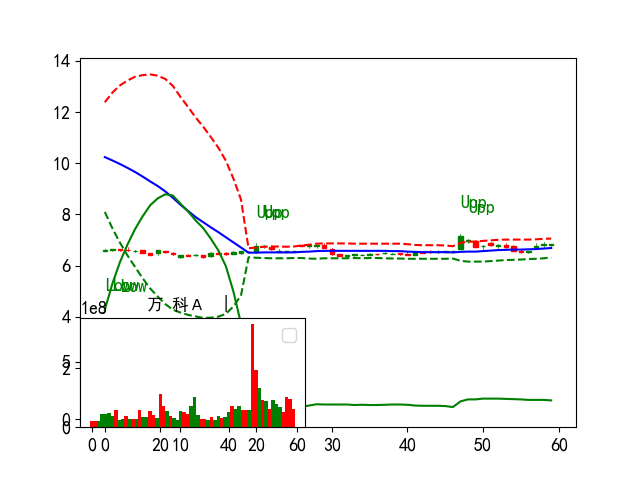

In [76]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [77]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [78]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-09-08    1.13
        2025-09-09    1.13
        2025-09-10    1.13
399001  2025-09-08    1.25
        2025-09-09    1.24
        2025-09-10    1.24
399006  2025-09-08    1.44
        2025-09-09    1.41
        2025-09-10    1.43
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [79]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 31


ra_diff  xratio  idx   hat  close  volsum5d   hmax   lmin  perc1d  \
date                                                                            
2025-07-31     1.07     0.0  0.0  1.23  18.17     214.5  19.31  17.19   28.05   
2025-08-01     1.05     0.0  0.0  1.17  17.91     184.4  19.31  17.19   -1.43   
2025-08-04     1.09     0.0  0.0  1.27  18.45     129.5  19.31  17.19    3.02   
2025-08-05     1.10     0.0  0.0  1.42  18.73     159.6  19.31  17.19    1.52   
2025-08-06     1.11     0.0  0.0  1.61  18.94     169.5  19.50  17.19    1.12   
2025-08-07     1.16     0.0  0.0  2.15  19.66     185.1  20.83  17.19    3.80   
2025-08-08     1.27     0.0  0.0  3.80  21.62     260.7  21.62  17.19    9.97   
2025-08-11     1.32     0.0  0.0  5.27  22.38     231.6  22.56  17.19    3.52   
2025-08-12     1.23     0.0  0.0  5.68  20.91     185.5  22.56  17.19   -6.57   
2025-08-13     1.21     0.0  0.0  5.88  20.58     166.4  22.56  17.19   -1.58   
2025-08-14     1.16     0.0  0.0  5.87  19.70       0.6  22.56  17.19   -4.28   
2025-08-15     1.18     0.0  0.0  5.87  20.02     -75.9  22.56  17.19    1.62   
2025-08-18     1.18     0.0  0.0  5.85  20.06     -96.2  22.56  17.19    0.20   
2025-08-19     1.22     0.0  0.0  5.78  20.70       4.6  22.56  17.28    3.19   
2025-08-20     1.23     0.0  0.0  5.71  20.91      14.1  22.56  17.31    1.01   
2025-08-21     1.19     0.0  0.0  5.43  20.23     -32.2  22.56  17.70   -3.25   
2025-08-22     1.20     0.0  0.0  5.24  20.45     -28.0  22.56  17.70    1.09   
2025-08-25     1.26     0.0  0.0  5.23  21.34     172.7  22.56  17.70    4.35   
2025-08-26     1.27     0.0  0.0  5.18  21.62     124.6  22.56  17.70    1.31   
2025-08-27     1.22     0.0  0.0  4.91  20.75     104.9  22.56  17.70   -4.02   

             ma20  ma250   vol1d   vol2d   vol3d   vol4d   vol5d  perc3d  \
date                                                                       
2025-07-31  13.98  13.25  154.80  -14.73  -24.77   97.80    1.44   29.79   
2025-08-01  14.19  13.26  -28.65  154.80  -14.73  -24.77   97.80   26.66   
2025-08-04  14.42  13.27   42.81  -28.65  154.80  -14.73  -24.77   30.02   
2025-08-05  14.68  13.29    5.36   42.81  -28.65  154.80  -14.73    3.08   
2025-08-06  14.93  13.30   -4.85    5.36   42.81  -28.65  154.80    5.75   
2025-08-07  15.23  13.32  170.47   -4.85    5.36   42.81  -28.65    6.56   
2025-08-08  15.63  13.35   46.95  170.47   -4.85    5.36   42.81   15.43   
2025-08-11  16.06  13.38   13.65   46.95  170.47   -4.85    5.36   18.16   
2025-08-12  16.41  13.40  -40.72   13.65   46.95  170.47   -4.85    6.36   
2025-08-13  16.77  13.42  -23.91  -40.72   13.65   46.95  170.47   -4.81   
2025-08-14  17.07  13.44    4.68  -23.91  -40.72   13.65   46.95  -11.97   
2025-08-15  17.39  13.46  -29.65    4.68  -23.91  -40.72   13.65   -4.26   
2025-08-18  17.70  13.48   -6.61  -29.65    4.68  -23.91  -40.72   -2.53   
2025-08-19  18.05  13.50   60.12   -6.61  -29.65    4.68  -23.91    5.08   
2025-08-20  18.41  13.53  -14.43   60.12   -6.61  -29.65    4.68    4.45   
2025-08-21  18.75  13.54  -41.64  -14.43   60.12   -6.61  -29.65    0.85   
2025-08-22  19.09  13.56  -25.39  -41.64  -14.43   60.12   -6.61   -1.21   
2025-08-25  19.45  13.58  194.04  -25.39  -41.64  -14.43   60.12    2.06   
2025-08-26  19.83  13.60   11.97  194.04  -25.39  -41.64  -14.43    6.87   
2025-08-27  20.16  13.62  -34.05   11.97  194.04  -25.39  -41.64    1.47   

            perc5d  
date                
2025-07-31   34.79  
2025-08-01   31.30  
2025-08-04   31.79  
2025-08-05   32.46  
2025-08-06   33.47  
2025-08-07    8.20  
2025-08-08   20.71  
2025-08-11   21.30  
2025-08-12   11.64  
2025-08-13    8.66  
2025-08-14    0.20  
2025-08-15   -7.40  
2025-08-18  -10.37  
2025-08-19   -1.00  
2025-08-20    1.60  
2025-08-21    2.69  
2025-08-22    2.15  
2025-08-25    6.38  
2025-08-26    4.44  
2025-08-27   -0.77

## !!! Run-Filter强势Upper

### !!! filterRule test

In [80]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 -0.03 -0.29


'Bear'

-0.29

date
2025-09-04    0.01
2025-09-05    0.01
2025-09-08    0.01
2025-09-09    0.00
2025-09-10   -0.00
Name: xratio, dtype: float64

xratio:-0.01 ra_diff:1.01
code: 601728


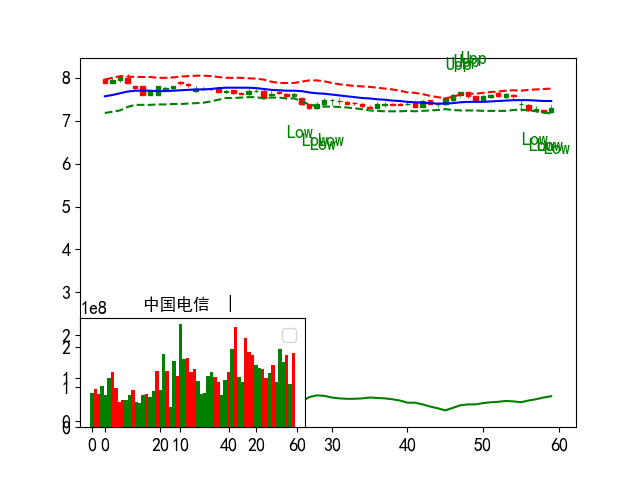

In [81]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [82]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

30
xratio:-0.07 ra_diff:1.0
code: 600012


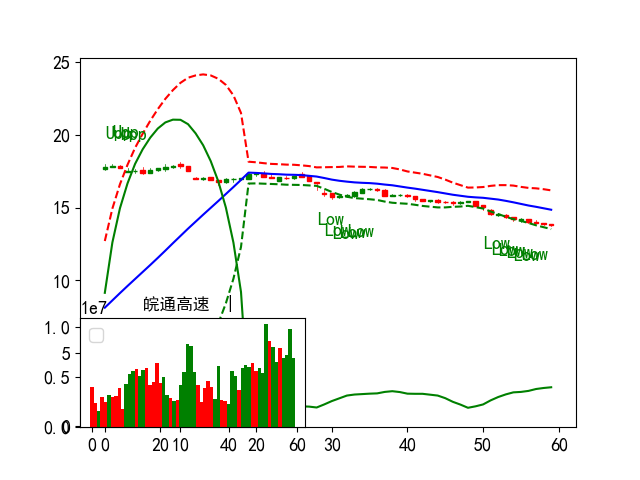

In [83]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [84]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 605298    17
 Name: couts, dtype: int64,
 (113, 40))

Count:113 40


name  couts       date   perc  ra_diff  xratio    idx     hat  \
code                                                                     
605298   必得科技     17 2025-09-10  -2.07     3.42    0.98  15.14   28.38   
301448   开创电气     15 2025-09-10  13.30     2.79    1.20  25.44   34.85   
301489   思泉新材     15 2025-09-10  20.03     4.36    2.74  41.13   76.81   
605255   天普股份     14 2025-09-10  10.05     4.45    1.91  43.78   65.68   
002558   巨人网络     14 2025-09-10  10.01     2.81    0.53  13.38   18.06   
001288   运机集团     13 2025-09-10  -1.39     1.30    0.12   1.50    3.72   
300790   宇瞳光学     13 2025-09-10  11.73     1.74    0.36   6.33   10.47   
300476   胜宏科技     13 2025-09-10  12.04     3.35    3.29  31.75  101.56   
601689   拓普集团     12 2025-09-10  -0.72     1.59    1.05  10.43   26.44   
603119   浙江荣泰     12 2025-09-10   6.44     2.55    1.50  30.76   47.56   
002058  *ST威尔     11 2025-09-10   5.04     1.94    0.31   5.69    9.57   
603615   茶花股份     11 2025-09-10   0.00     1.36    0.22   1.25    5.62   
603226   菲林格尔     11 2025-09-10   6.34     3.91    0.20   5.24    7.99   
300842   帝科股份     11 2025-09-10   2.27     1.40    0.47   8.15   13.76   
603163   圣晖集成     11 2025-09-10  10.00     1.90    0.64  10.31   20.55   
300428   立中集团     10 2025-09-10  10.80     1.40    0.15   2.11    4.79   
002106   莱宝高科     10 2025-09-10   2.01     1.23    0.05   0.55    1.64   
300857   协创数据     10 2025-09-10  11.30     1.68    1.47  26.25   37.27   
002555   三七互娱     10 2025-09-10  -2.33     1.52    0.24   2.67    7.15   
603090   宏盛股份     10 2025-09-10   8.26     1.98    0.46  11.53   17.58   

         close  volsum5d  ...    ma20  ma250    llow    vol1d  vol2d   vol3d  \
code                      ...                                                  
605298   43.00     137.7  ...   29.77  15.40   40.84   107.86 -23.22   80.91   
301448   65.25     118.0  ...   42.40  31.75   56.09    23.67  15.52   61.44   
301489  229.25     107.5  ...  187.45  64.99  201.00    45.40  10.16    1.65   
605255   76.00     962.9  ...   38.79  25.41   76.00   -50.32  72.46  922.69   
002558   43.97      39.1  ...   32.83  13.03   39.25    75.57 -20.49    8.27   
001288   25.62     335.3  ...   24.11  22.15   25.30   133.40 -11.63  -45.71   
300790   34.38     164.5  ...   28.91  22.89   30.20   171.55 -28.43   21.71   
300476  290.75      61.5  ...  248.21  54.49  266.00    41.93 -22.60   -7.53   
601689   69.12      23.3  ...   59.67  23.68   68.75    12.60   1.63   66.43   
603119  101.38      -9.2  ...   75.28  24.59   90.62    -8.37  -5.89    8.01   
002058   21.66     884.0  ...   16.64   6.89   21.31  1014.06  31.57  -94.64   
603615   27.91      87.1  ...   25.52  11.25   27.08    29.07 -27.50    5.75   
603226   29.19      44.5  ...   23.67  21.58   26.84    12.34   6.00  -13.11   
300842   54.59      27.2  ...   48.96  35.35   53.00     0.50  16.55  -28.39   
603163   50.81      23.3  ...   38.98  17.63   46.25    34.37  13.13   12.58   
300428   23.70     292.9  ...   20.46  17.47   21.20   289.48   5.93  -21.17   
002106   12.20     150.9  ...   11.47   6.12   11.88    19.97 -38.69   22.11   
300857  128.00      77.2  ...  101.98  37.63  116.00    53.97 -24.10   49.15   
002555   22.20      43.2  ...   19.15  17.90   22.02   -15.60   1.29   -2.63   
603090   45.47      26.2  ...   36.62  21.88   41.38    20.31  30.61  -24.81   

         vol4d   vol5d  perc3d  perc5d  
code                                    
605298  -42.35   14.46   18.42   23.28  
301448   16.50    0.88   37.63   46.43  
301489  -21.13   71.47   18.17    6.13  
605255  -69.14   87.17   33.12   61.05  
002558   -7.75  -16.52   14.56   21.94  
001288  -12.63  271.91    0.55   12.22  
300790  -32.47   32.10   13.43    7.50  
300476   17.05   32.68   -1.69    7.59  
601689  -29.95  -27.38    9.06    6.34  
603119   37.50  -40.45   26.92   12.96  
002058  -25.63  -41.37   15.83   15.40  
603615   56.61   23.20    3.45   10.32  
603226   26.94   12.36   15.60   29.22  
3008

#### !!! hmax Top upper > 1

In [85]:
# dfs_tail9.loc['600103']

In [86]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
 # by=['volsum5d', 'idx', 'hat', 'perc1d'],
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])
show_tdx_data(df_mask_hmax.query('couts >= 1 and perc >2  and   low < ma5 '),limit=10 )

count dd.couts
compute percent
code
605580    13
Name: couts, dtype: int64 (173, 40)


(code
 605580    13
 Name: couts, dtype: int64,
 (173, 40))

Count:30 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
002558  巨人网络     11 2025-09-10  10.01     2.81    0.53  13.38  18.06  43.97   
002115  三维通信      7 2025-09-10  10.04     1.77    0.21   4.29   6.78  13.81   
603101  汇嘉时代      7 2025-09-10   9.98     1.84    0.19   3.27   5.83  13.44   
300428  立中集团      7 2025-09-10  10.80     1.40    0.15   2.11   4.79  23.70   
300956  英力股份      7 2025-09-10  10.42     1.30    0.04   1.83   2.40  19.39   
000025  特 力Ａ      6 2025-09-10   2.51     1.14    0.04   1.52   1.78  19.16   
002101  广东鸿图      6 2025-09-10   9.98     1.18    0.00   1.41   1.76  14.43   
603237   五芳斋      6 2025-09-10   2.35     1.15    0.05   1.30   1.83  19.16   
300043  星辉娱乐      6 2025-09-10   9.25     1.44    0.05   0.83   1.35   5.79   
300997   欢乐家      5 2025-09-10   8.14     1.39    0.21   4.81   6.88  21.92   

        volsum5d  ...   ma20  ma250   llow   vol1d  vol2d  vol3d   vol4d  \
code              ...                                                      
002558      39.1  ...  32.83  13.03  39.25   75.57 -20.49   8.27   -7.75   
002115      26.0  ...  10.11  11.91  11.97   -7.69  35.85  -3.26  -22.97   
603101     218.2  ...  10.40  19.05  11.61  103.55 -38.89 -25.74  209.24   
300428     292.9  ...  20.46  17.47  21.20  289.48   5.93 -21.17   10.41   
300956     440.7  ...  17.59  30.08  17.59  427.05  11.72  -0.89   -3.78   
000025      92.2  ...  17.99  17.10  18.16    6.88  18.98  -8.53  103.29   
002101     173.2  ...  13.23  11.96  13.00  151.98  30.61   5.78   -6.95   
603237     253.1  ...  18.05  21.52  18.55   47.28   5.62 -24.74  -34.45   
300043     147.2  ...   5.01  17.61   5.27  153.44 -28.71  13.43   14.35   
300997     163.2  ...  17.87  29.93  19.06   10.70   7.08 -11.89   -2.37   

         vol5d  perc3d  perc5d  
code                            
002558  -16.52   14.56   21.94  
002115   24.10   24.98   20.61  
603101  -29.92   15.27   36.45  
300428    8.23   12.75   15.95  
300956    6.58   12.02   15.35  
000025  -28.40    4.07    8.25  
002101   -8.24   12.73   14.16  
603237  259.40    3.68    9.80  
300043   -5.26    9.25   12.65  
300997  159.64   11.27   28.34  

[10 rows x 23 columns]

In [87]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [88]:
show_tdx_data(
    df_mask_hmax.query('perc > 1').sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')

Count:127 40


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  \
code                                                                      
605255   天普股份     12 2025-09-10  10.05     4.45     4.45    1.91  43.78   
301489   思泉新材      7 2025-09-10  20.03     4.36     4.36    2.74  41.13   
603226   菲林格尔      6 2025-09-10   6.34     3.91     3.91    0.20   5.24   
300528   幸福蓝海      3 2025-09-10  13.87     3.12     3.12    0.23  11.82   
002558   巨人网络     11 2025-09-10  10.01     2.81     2.81    0.53  13.38   
301448   开创电气     10 2025-09-10  13.30     2.79     2.79    1.20  25.44   
603119   浙江荣泰      7 2025-09-10   6.44     2.55     2.55    1.50  30.76   
002384   东山精密      3 2025-09-10  10.10     2.42     2.42    0.66  11.31   
605580   恒盛能源     13 2025-09-10   1.31     2.37     2.37    0.33   6.85   
002759   天际股份      7 2025-09-10   4.40     2.34     2.34    0.27   7.45   
002602   ST华通      9 2025-09-10   3.51     2.07     2.07    0.20   4.07   
300716   ST泉为      8 2025-09-10   9.35     2.02     2.02    0.20   4.05   
002846   英联股份      8 2025-09-10   1.93     1.99     1.99    0.26   6.97   
600376   首开股份      5 2025-09-10  10.12     1.97     1.97    0.05   2.00   
002058  *ST威尔      9 2025-09-10   5.04     1.94     1.94    0.31   5.69   
603163   圣晖集成      7 2025-09-10  10.00     1.90     1.90    0.64  10.31   
603101   汇嘉时代      7 2025-09-10   9.98     1.84     1.84    0.19   3.27   
600730   中国高科      3 2025-09-10   3.54     1.78     1.78    0.11   1.60   
002115   三维通信      7 2025-09-10  10.04     1.77     1.77    0.21   4.29   
301216   万凯新材      5 2025-09-10   6.88     1.74     1.74    0.18   3.83   

          hat   close  ...    ma20  ma250    llow    vol1d    vol2d   vol3d  \
code                   ...                                                    
605255  65.68   76.00  ...   38.79  25.41   76.00   -50.32    72.46  922.69   
301489  76.81  229.25  ...  187.45  64.99  201.00    45.40    10.16    1.65   
603226   7.99   29.19  ...   23.67  21.58   26.84    12.34     6.00  -13.11   
300528  12.51   29.30  ...   19.13  23.36   24.95    24.11     2.31  -10.38   
002558  18.06   43.97  ...   32.83  13.03   39.25    75.57   -20.49    8.27   
301448  34.85   65.25  ...   42.40  31.75   56.09    23.67    15.52   61.44   
603119  47.56  101.38  ...   75.28  24.59   90.62    -8.37    -5.89    8.01   
002384  25.38   72.25  ...   59.52  16.69   65.38    -4.32   -22.98   25.01   
605580  10.99   26.23  ...   20.27  29.59   24.53     4.39    10.64   22.72   
002759   9.83   17.55  ...   11.50  11.28   15.80    90.66  1016.65  -28.34   
002602   6.70   18.86  ...   15.16  15.90   17.70     6.21     0.67   -5.30   
300716   5.85   13.45  ...   10.05  32.39   12.37    14.55   -21.66   57.42   
002846   9.17   22.66  ...   17.99  33.35   21.12    17.19     9.20  -13.01   
600376   2.36    4.68  ...    3.02  14.12    4.34    12.81   -52.07  -19.23   
002058   9.57   21.66  ...   16.64   6.89   21.31  1014.06    31.57  -94.64   
603163  20.55   50.81  ...   38.98  17.63   46.25    34.37    13.13   12.58   
603101   5.83   13.44  ...   10.40  19.05   11.61   103.55   -38.89  -25.74   
600730   2.89   11.11  ...    9.67   9.30   10.51    23.05   -22.61    9.37   
002115   6.78   13.81  ...   10.11  11.91   11.97    -7.69    35.85   -3.26   
301216   5.87   21.14  ...   17.35  29.90   19.31    35.48     2.65  -23.06   

         vol4d  vol5d  perc3d  perc5d  
code                                   
605255  -69.14  87.17   33.12   61.05  
301489  -21.13  71.47   18.17    6.13  
603226   26.94  12.36   15.60   29.22  
300528   74.69  15.63   41.41   64.51  
002558   -7.75 -16.52   14.56   21.94  
301448   16.50   0.88   37.63   46.43  
603119   37.50 -40.45   26.92   12.96  
002384   11.73  28.68   12.89   11.81  
605580  -24.46  38.69   15.86   22.00  
002759  -59.24 -42.29   26.35   52.87  
002602  -14.93   3.57   13.96   13.75  
300716  -13.75  18.09   20.84   22.72  
002846    2.25   0.63    6.34   18.76  
600376  203.80  -9.

xratio:-0.01 ra_diff:1.16
code: 300540


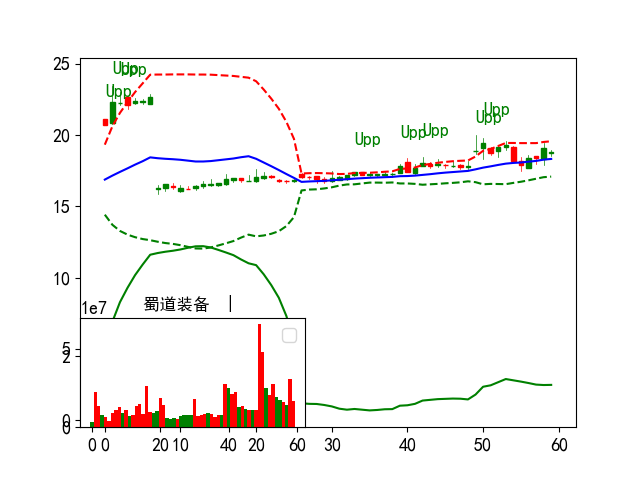

In [89]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio 加速

In [90]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_mask250.loc[cross_hmax_250].query('couts > 1 and perc > 0'))
# show_tdx_data(df_mask250.query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.loc[code_t])

(532, 31)

count dd.couts
(code    date      
605255  2025-08-29    6
        2025-09-01    6
        2025-09-02    6
Name: couts, dtype: int64, (396, 32))
compute percent
df_mask250:199 df_mask_hmax:173
cross_hamx:42
Count:19 40


name  couts       date   perc  ra_diff  xratio    idx    hat   close  \
code                                                                            
605255   天普股份      6 2025-09-10  10.05     4.45    1.91  43.78  65.68   76.00   
603119   浙江荣泰      3 2025-09-10   6.44     2.55    1.50  30.76  47.56  101.38   
301448   开创电气      3 2025-09-10  13.30     2.79    1.20  25.44  34.85   65.25   
002558   巨人网络      4 2025-09-10  10.01     2.81    0.53  13.38  18.06   43.97   
002812   恩捷股份      4 2025-09-10  10.03     1.67    0.34  12.09  13.78   43.56   
300528   幸福蓝海      2 2025-09-10  13.87     3.12    0.23  11.82  12.51   29.30   
603163   圣晖集成      2 2025-09-10  10.00     1.90    0.64  10.31  20.55   50.81   
301333    诺思格      2 2025-09-10   2.28     1.33    0.10   8.53   8.64   60.00   
300139   晓程科技      2 2025-09-10   0.26     1.45    0.29   7.93  10.75   27.41   
002759   天际股份      3 2025-09-09   4.40     2.24    0.22   6.95   8.12   17.55   
301015   百洋医药      2 2025-09-10   0.87     1.75    0.17   6.53   7.46   31.30   
002058  *ST威尔      2 2025-09-10   5.04     1.94    0.31   5.69   9.57   21.66   
603226   菲林格尔      2 2025-09-10   6.34     3.91    0.20   5.24   7.99   29.19   
600977   中国电影      3 2025-09-09   0.63     1.67    0.11   4.58   5.19   17.70   
002602   ST华通      4 2025-09-10   3.51     2.07    0.20   4.07   6.70   18.86   
603100   川仪股份      3 2025-09-10   2.41     1.21    0.12   3.23   4.51   24.23   
301148   嘉戎技术      2 2025-09-10   1.26     1.35    0.04   2.93   4.16   28.16   
002237   恒邦股份      2 2025-09-10   3.54     1.35    0.09   2.80   3.32   15.23   
300382    斯莱克      2 2025-09-10   4.37     1.20    0.02   2.66   2.83   16.94   

        volsum5d  ...   ma20  ma250   llow    vol1d   vol2d   vol3d  vol4d  \
code              ...                                                        
605255     962.9  ...  38.79  25.41  76.00   -50.32   72.46  922.69 -69.14   
603119      -9.2  ...  75.28  24.59  90.62    -8.37   -5.89    8.01  37.50   
301448     118.0  ...  42.40  31.75  56.09    23.67   15.52   61.44  16.50   
002558      39.1  ...  32.83  13.03  39.25    75.57  -20.49    8.27  -7.75   
002812      97.2  ...  33.65  18.60  38.78    -7.64  -24.74   65.26   1.85   
300528     106.4  ...  19.13  23.36  24.95    24.11    2.31  -10.38  74.69   
603163      23.3  ...  38.98  17.63  46.25    34.37   13.13   12.58 -11.34   
301333     117.0  ...  55.44  44.32  58.09    31.94   23.31  -33.78  33.75   
300139      88.9  ...  21.07  11.99  24.80    -9.63  126.30  -21.00   3.30   
002759     947.0  ...  11.11  11.24  16.20  1016.65  -28.34  -59.24 -42.29   
301015      16.6  ...  26.45  25.62  30.25   -40.82    7.66   42.51  27.72   
002058     884.0  ...  16.64   6.89  21.31  1014.06   31.57  -94.64 -25.63   
603226      44.5  ...  23.67  21.58  26.84    12.34    6.00  -13.11  26.94   
600977     220.9  ...  13.80  10.80  16.88   136.44  -16.85  145.08 -19.16   
002602      -9.8  ...  15.16  15.90  17.70     6.21    0.67   -5.30 -14.93   
603100     196.5  ...  21.34  21.88  23.34    -6.77   39.35  -38.05 -28.37   
301148     290.5  ...  25.56  21.06  27.45   -15.32   -1.84  324.19   2.45   
002237     226.2  ...  12.90  10.73  14.13   235.90   11.28  -13.05  -1.23   
300382     280.8  ...  15.10  13.62  15.88    40.04  -19.96   67.68 -25.96   

         vol5d  perc3d  perc5d  
code                            
605255   87.17   33.12   61.05  
603119  -40.45   26.92   12.96  
301448    0.88   37.63   46.43  
002558  -16.52   14.56   21.94  
002812   62.50   17.83   33.13  
300528   15.63   41.41   64.51  
603163  -25.39   15.06   13.47  
301333   61.81    3.39    8.91  
300139  -10.05   17.79   24.31  
002759   60.18   33.10   49.69  
301015  -20.48   15.24   19.74  
002058  -41.37   15.83   15.40  
603226   12.36   15.60   29.22  
600977  -24.65   28.86   24.75  
002602    3.57   13.96   13.75  
603100  230.35    6.93   17.85  
301148  -19.00   12.73   16.27  
002237   -6.71   13.83   15.03  
300382  

df_mask250:34
605255 4.45
xratio:0.54 ra_diff:4.45
code: 605255


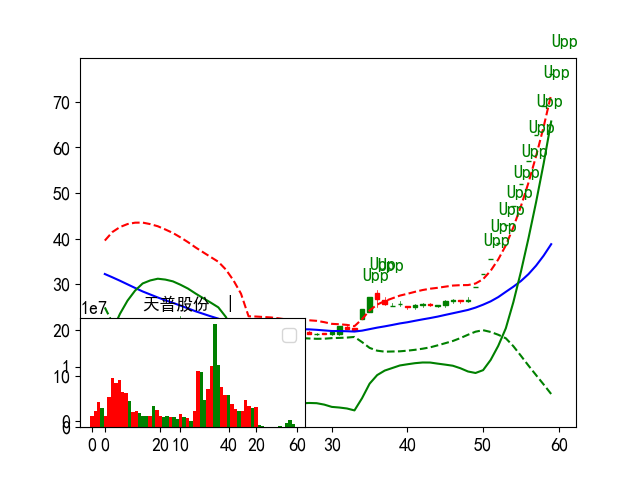

603119 2.55
xratio:0.84 ra_diff:2.55
code: 603119


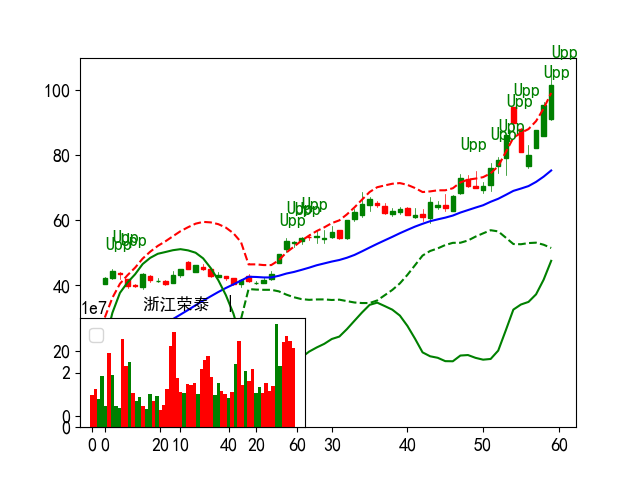

300450 2.94
xratio:0.4 ra_diff:2.94
code: 300450


301448 2.79
xratio:0.44 ra_diff:2.79
code: 301448


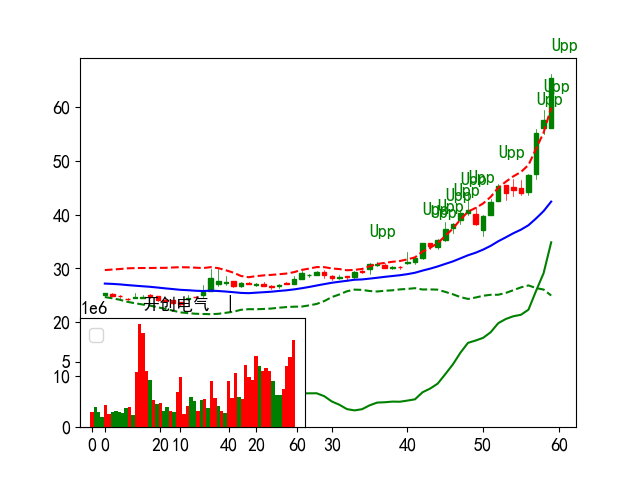

300469 2.57
xratio:0.64 ra_diff:2.57
code: 300469


002975 1.94
xratio:0.49 ra_diff:1.94
code: 002975


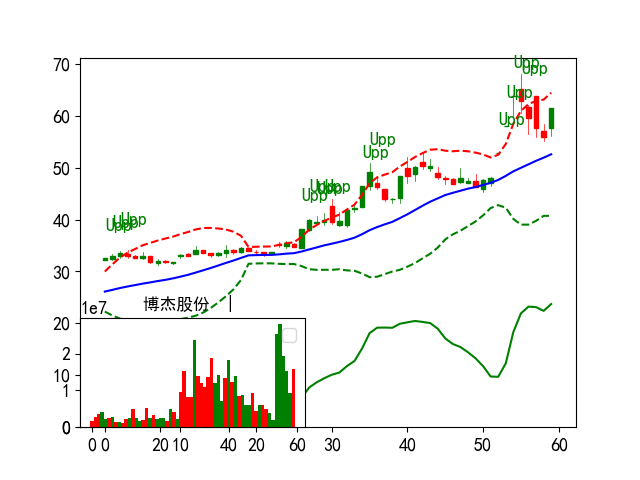

601069 1.76
xratio:0.08 ra_diff:1.76
code: 601069


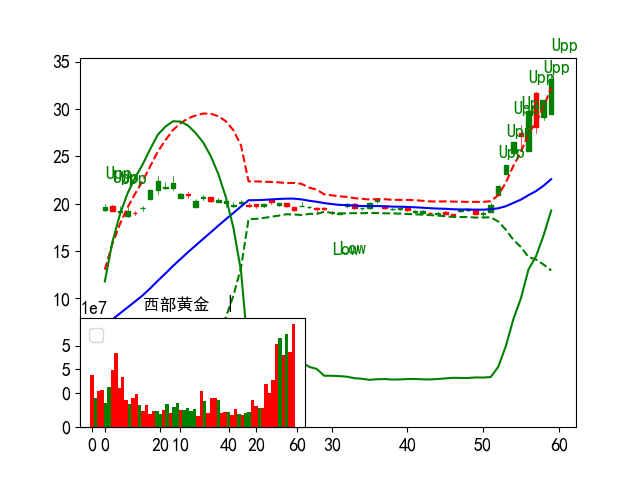

603099 1.48
xratio:0.21 ra_diff:1.48
code: 603099


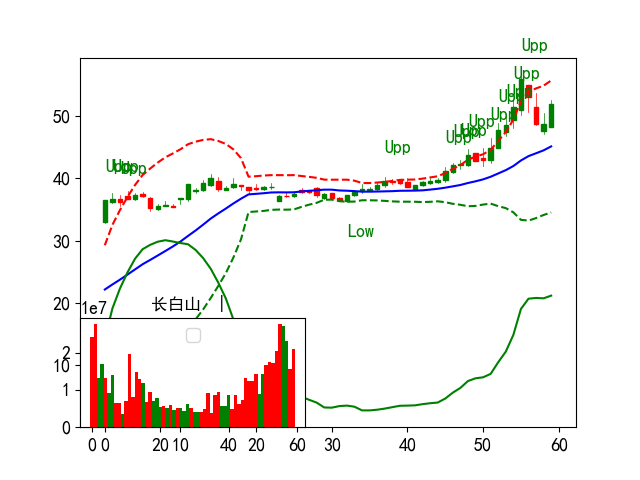

002558 2.81
xratio:0.32 ra_diff:2.81
code: 002558


002812 1.67
xratio:0.15 ra_diff:1.67
code: 002812


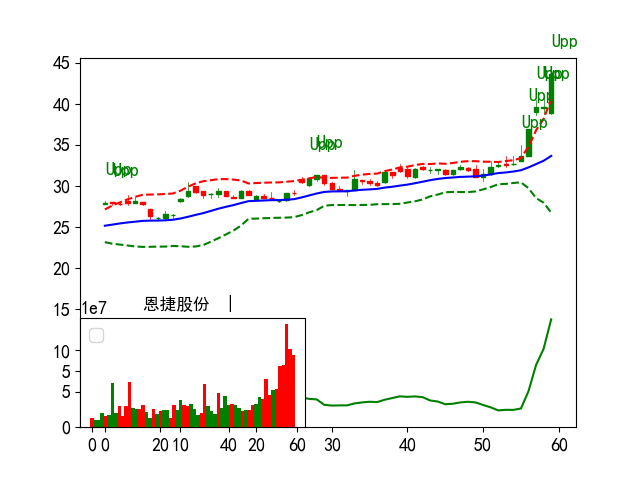

In [91]:
print("df_mask250:%s"%(len(df_mask250.query('couts > 1 and perc > 0'))))
for co in df_mask250.query('couts > 1 and perc > 0').index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [92]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date  lopen  lhigh   llow  close         vol        amount  \
code                                                                      
300308 2025-09-03  392.0  430.0  379.0  385.0  71235176.0  2.871663e+10   
605255 2025-09-10   76.0   76.0   76.0   76.0    567754.0  4.314930e+07   

        ra_diff    ma10     ma5  ...  xratio     idx  couts  name   open  \
code                             ...                                       
300308     4.38  343.35  386.05  ...    9.10  161.00      1  中际旭创  378.0   
605255     4.45   51.36   63.37  ...    1.91   43.78      6  天普股份   76.0   

         high    low  llastp            ticktime   perc  
code                                                     
300308  395.5  370.5  359.25 2025-09-10 15:35:15   7.17  
605255   76.0   76.0   69.06 2025-09-10 15:00:02  10.05  

[2 rows x 40 columns]

(138, 40)

In [93]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])
if df_masklastd is not None and len(df_masklastd) > 0:

    code_t = '300675'
    code_t = '605268'
    code_t = '002828'
    code_t = '300418'
    code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(199, 40)  lastd:(40, 40) 
code
300528     幸福蓝海
301448     开创电气
605255     天普股份
300857     协创数据
002181    粤 传 媒
601116     三江购物
600689     上海三毛
002812     恩捷股份
300139     晓程科技
603301     振德医疗
002058    *ST威尔
603226     菲林格尔
600699     均胜电子
002545     东方铁塔
301015     百洋医药
603163     圣晖集成
301150     中一科技
002558     巨人网络
002695      煌上煌
002237     恒邦股份
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:173
605580 2.37
xratio:0.2 ra_diff:2.37
code: 605580


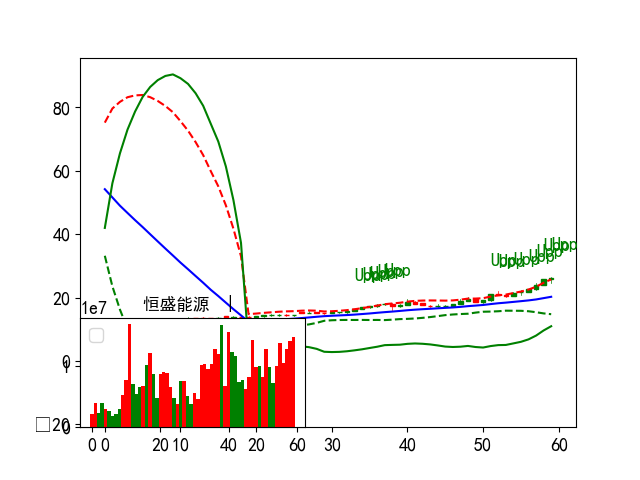

605255 4.45
xratio:0.54 ra_diff:4.45
code: 605255


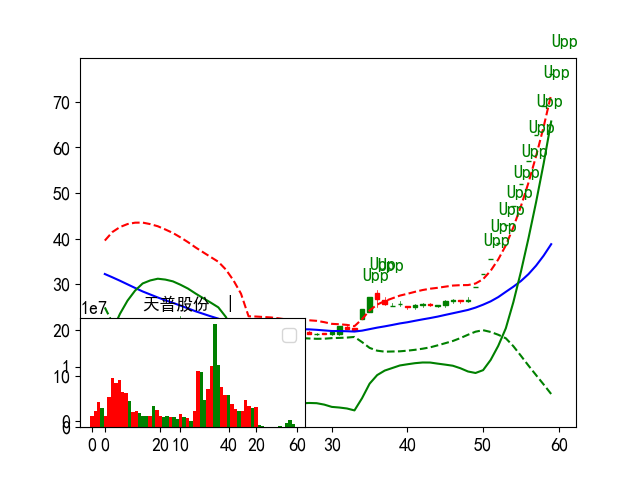

605298 3.42
xratio:0.41 ra_diff:3.42
code: 605298


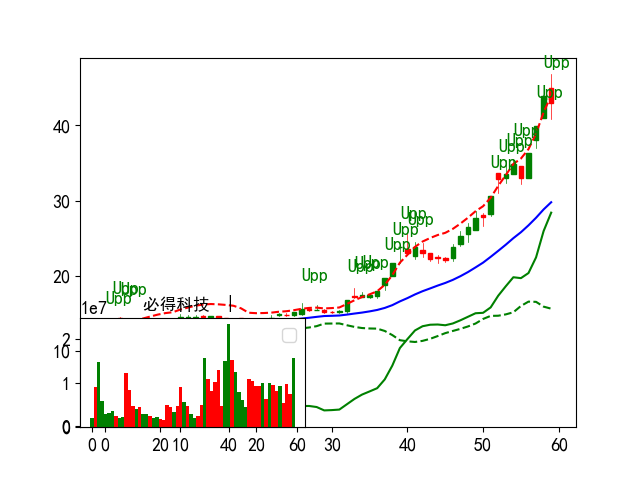

002558 2.81
xratio:0.32 ra_diff:2.81
code: 002558


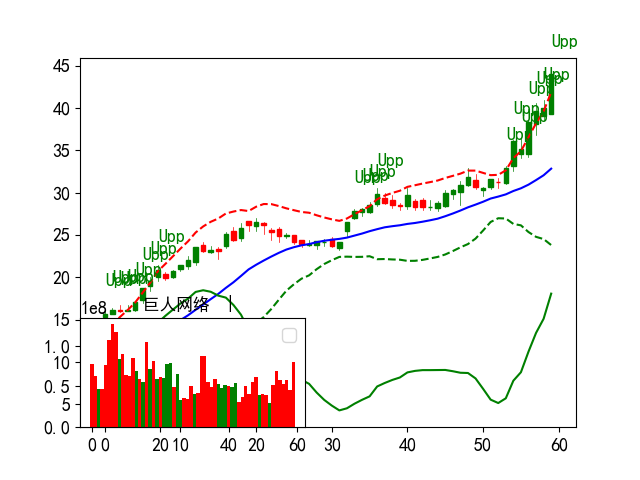

301448 2.79
xratio:0.44 ra_diff:2.79
code: 301448


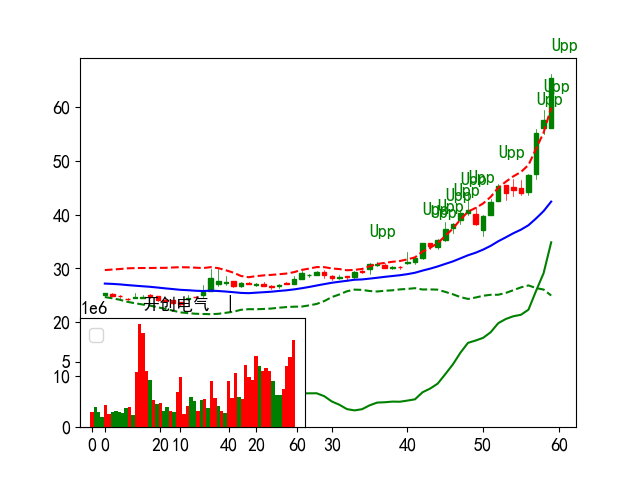

002058 1.94
xratio:0.11 ra_diff:1.94
code: 002058


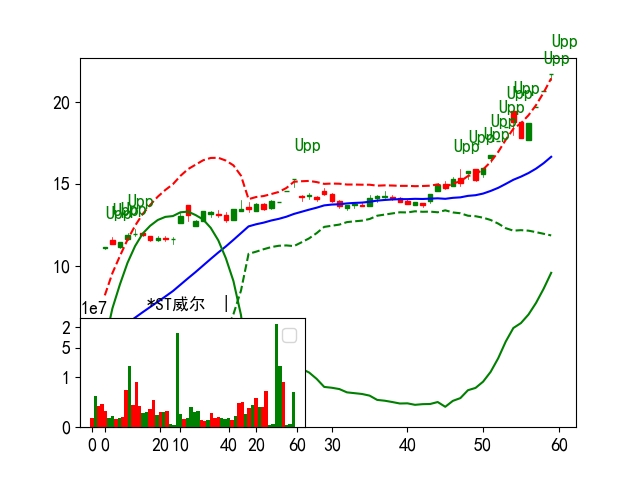

002602 2.07
xratio:0.12 ra_diff:2.07
code: 002602


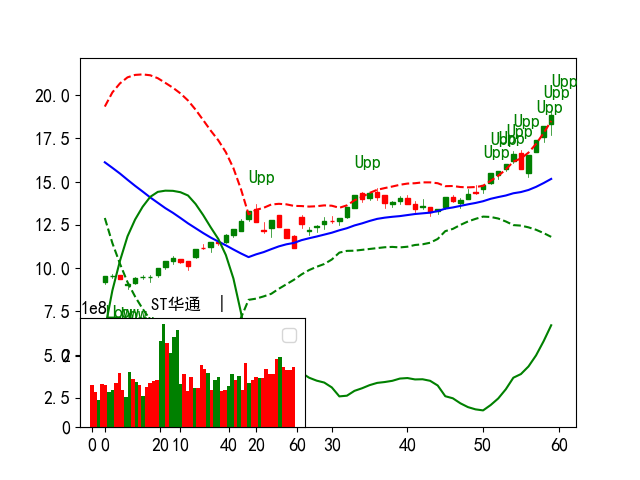

605287 1.42
xratio:0.06 ra_diff:1.42
code: 605287


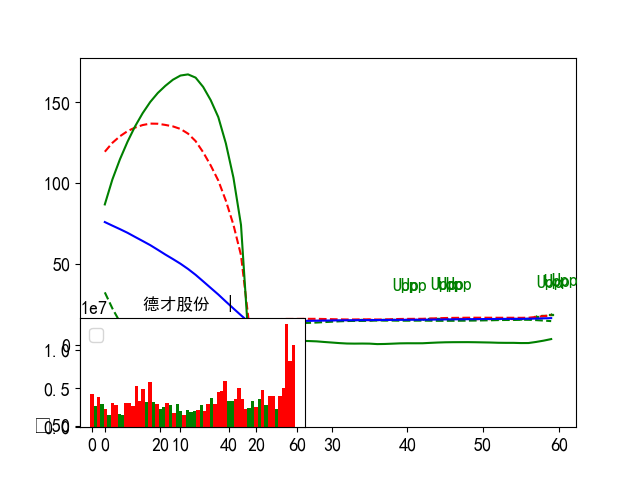

300097 1.33
xratio:0.02 ra_diff:1.33
code: 300097


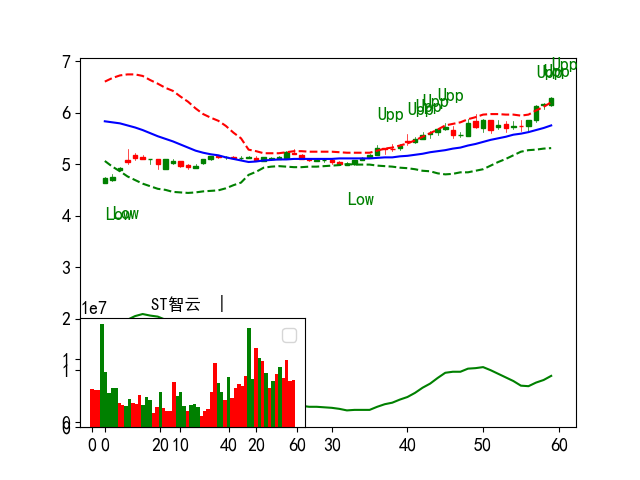

002846 1.99
xratio:0.09 ra_diff:1.99
code: 002846


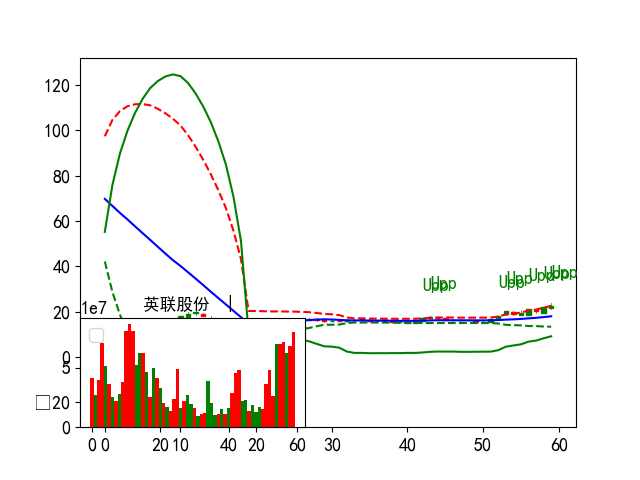

300716 2.02
xratio:0.07 ra_diff:2.02
code: 300716


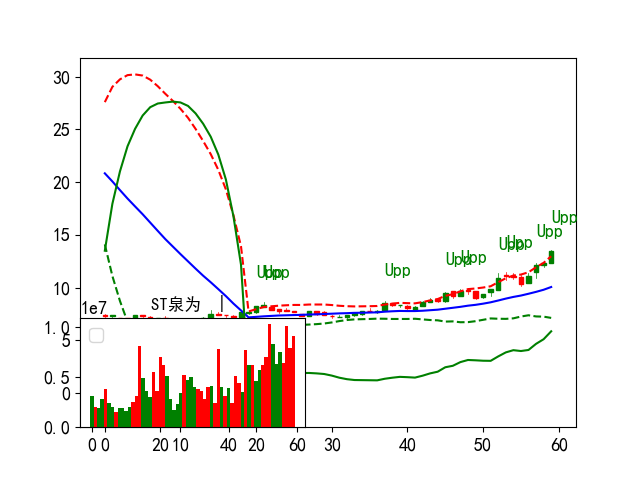

300931 1.68
xratio:0.07 ra_diff:1.68
code: 300931


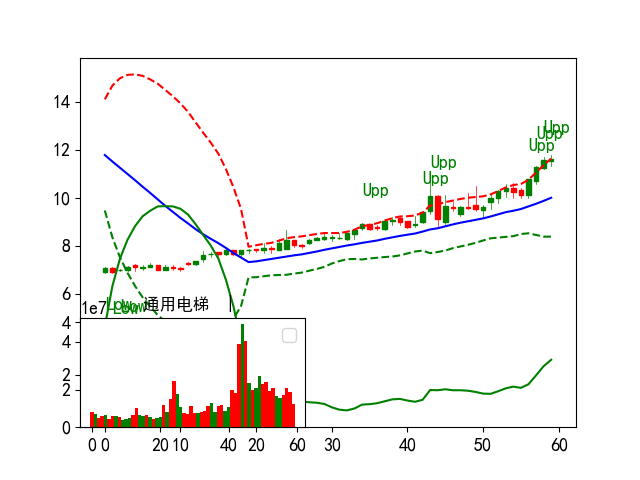

600103 1.59
xratio:0.01 ra_diff:1.59
code: 600103


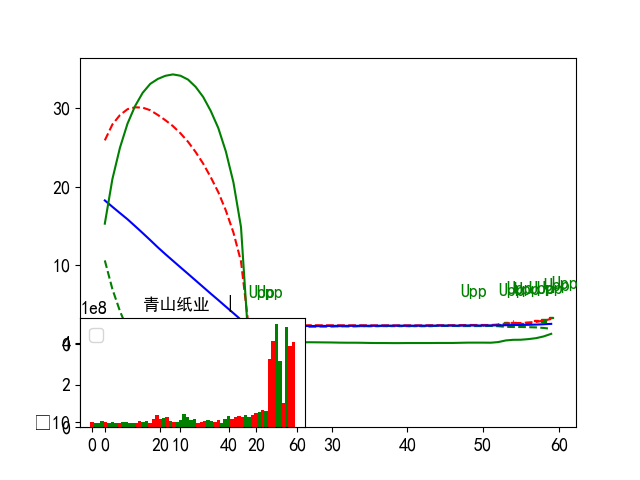

000972 1.73
xratio:0.02 ra_diff:1.73
code: 000972


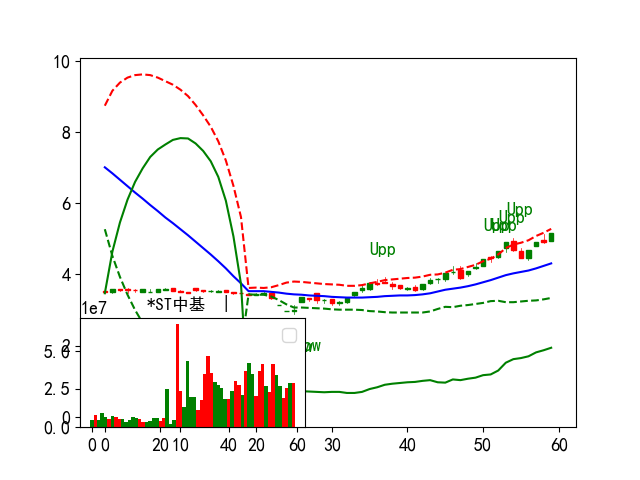

000980 1.69
xratio:0.01 ra_diff:1.69
code: 000980


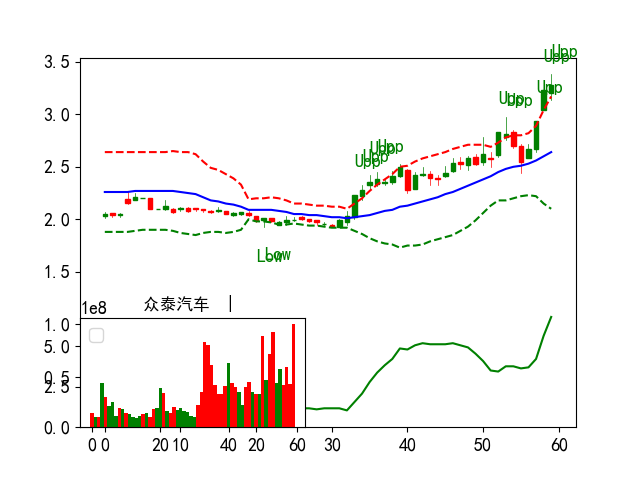

601598 1.22
xratio:0.02 ra_diff:1.22
code: 601598


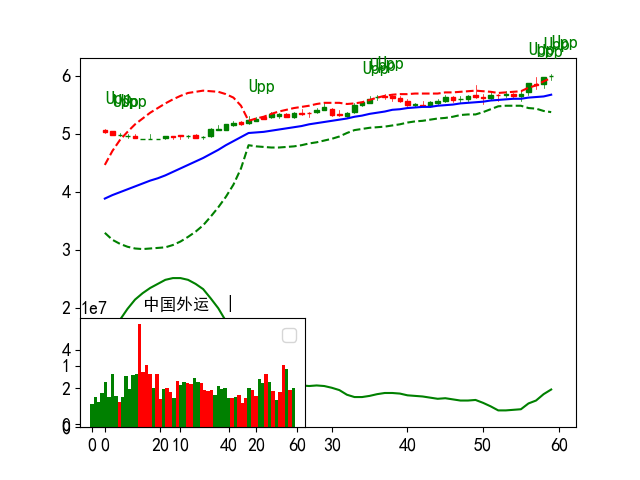

301489 4.36
xratio:3.19 ra_diff:4.36
code: 301489


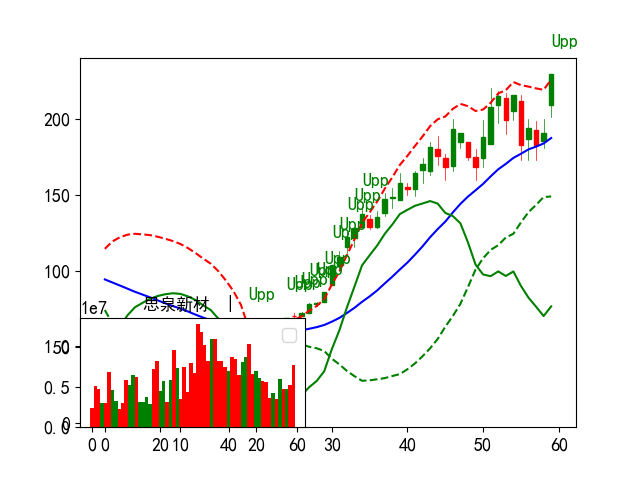

603119 2.55
xratio:0.84 ra_diff:2.55
code: 603119


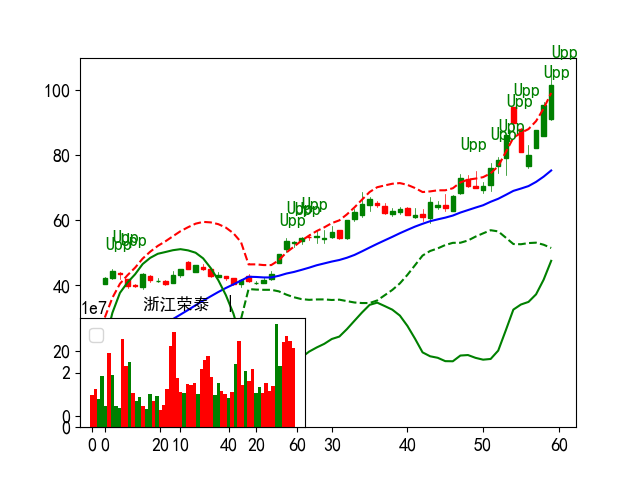

300857 1.68
xratio:0.45 ra_diff:1.68
code: 300857


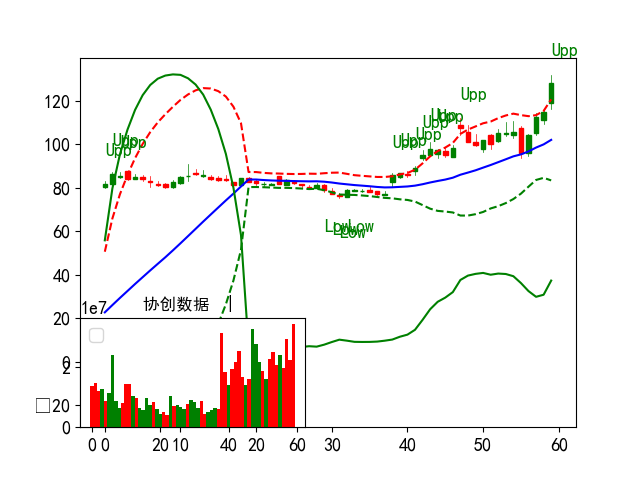

603163 1.9
xratio:0.29 ra_diff:1.9
code: 603163


In [94]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:20]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:40
300528 3.12
xratio:0.22 ra_diff:3.12
code: 300528


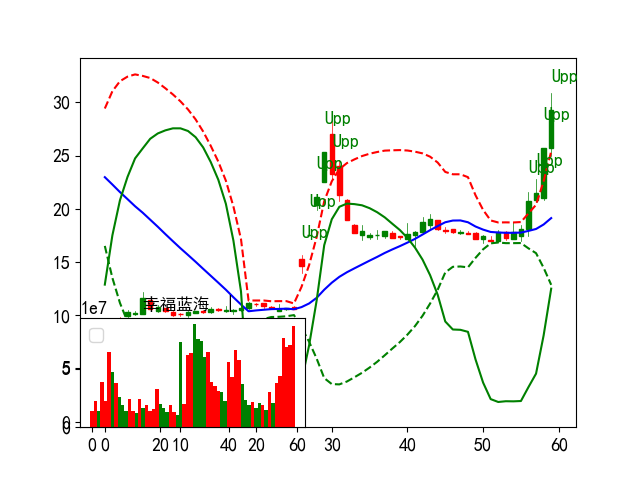

301448 2.79
xratio:0.44 ra_diff:2.79
code: 301448


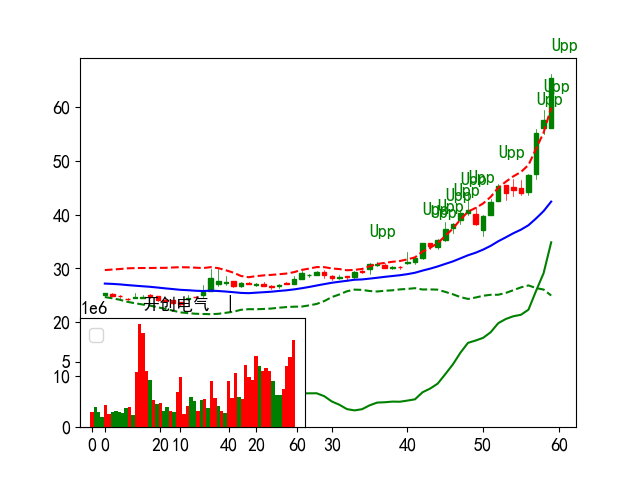

605255 4.45
xratio:0.54 ra_diff:4.45
code: 605255


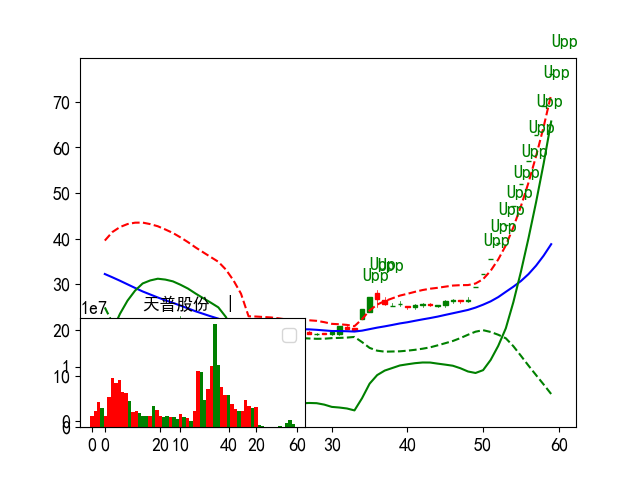

300857 1.68
xratio:0.45 ra_diff:1.68
code: 300857


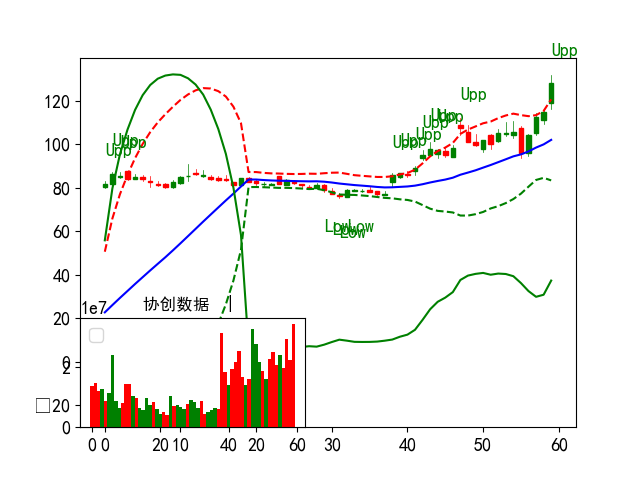

002181 1.6
xratio:0.01 ra_diff:1.6
code: 002181


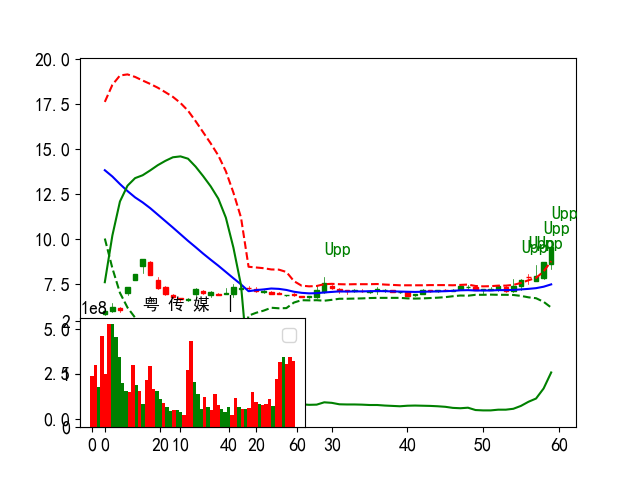

601116 1.4
xratio:0.02 ra_diff:1.4
code: 601116


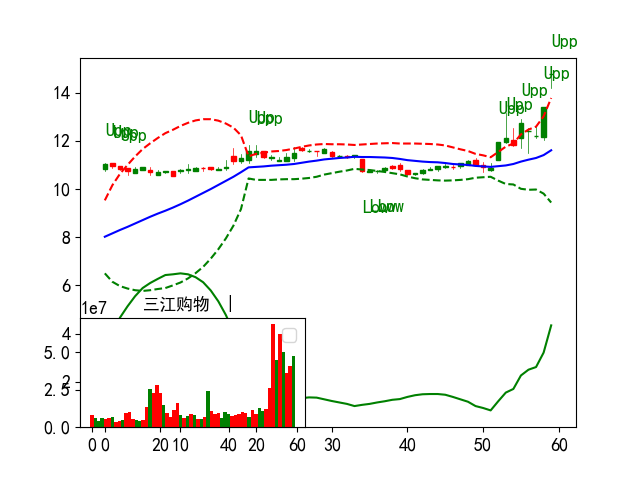

600689 1.39
xratio:0.04 ra_diff:1.39
code: 600689


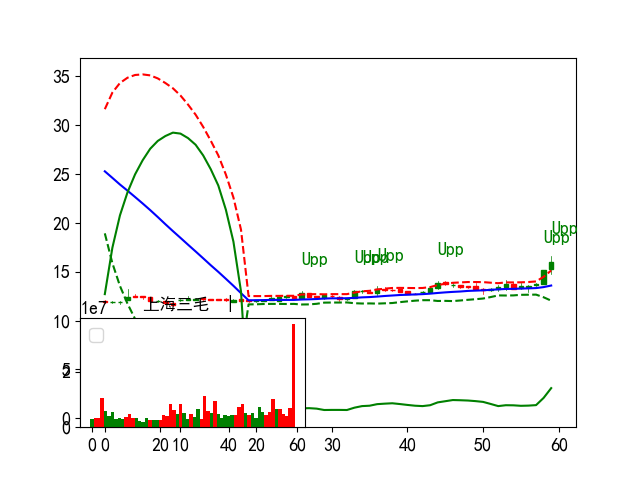

002812 1.67
xratio:0.15 ra_diff:1.67
code: 002812


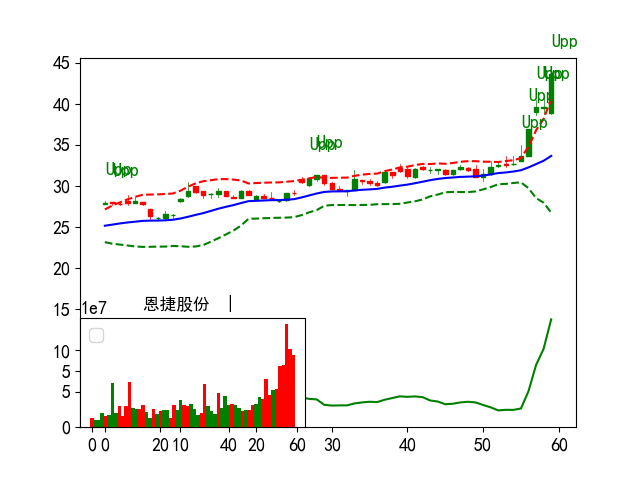

300139 1.45
xratio:0.03 ra_diff:1.45
code: 300139


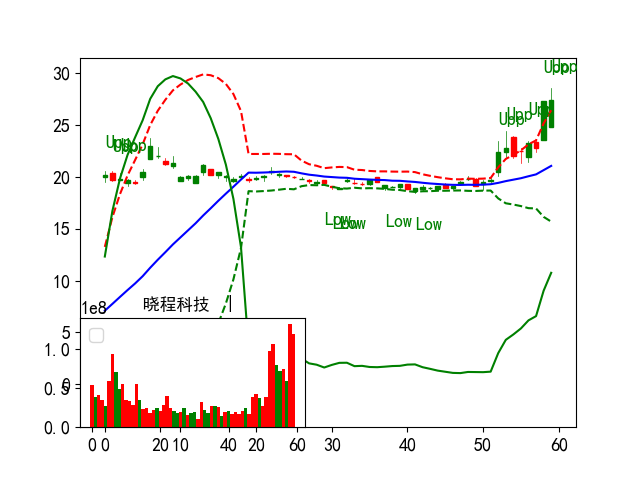

603301 1.48
xratio:0.11 ra_diff:1.48
code: 603301


In [95]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [96]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250],limit=5)

cross_hamx:32
Count:32 40


name  couts       date   perc  ra_diff  xratio    idx    hat   close  \
code                                                                            
300528   幸福蓝海      2 2025-09-10  13.87     3.12    0.23  11.82  12.51   29.30   
301448   开创电气      3 2025-09-10  13.30     2.79    1.20  25.44  34.85   65.25   
605255   天普股份      6 2025-09-10  10.05     4.45    1.91  43.78  65.68   76.00   
300857   协创数据      1 2025-09-10  11.30     1.68    1.47  26.25  37.27  128.00   
002181  粤 传 媒      1 2025-09-10   9.99     1.60    0.06   2.38   2.58    9.58   

        volsum5d  ...    ma20  ma250    llow  vol1d  vol2d   vol3d  vol4d  \
code              ...                                                       
300528     106.4  ...   19.13  23.36   24.95  24.11   2.31  -10.38  74.69   
301448     118.0  ...   42.40  31.75   56.09  23.67  15.52   61.44  16.50   
605255     962.9  ...   38.79  25.41   76.00 -50.32  72.46  922.69 -69.14   
300857      77.2  ...  101.98  37.63  116.00  53.97 -24.10   49.15 -17.71   
002181      38.6  ...    7.48   9.57    8.36  -6.03  10.68   -9.60   8.62   

        vol5d  perc3d  perc5d  
code                           
300528  15.63   41.41   64.51  
301448   0.88   37.63   46.43  
605255  87.17   33.12   61.05  
300857  15.92   23.08   21.40  
002181  34.97   21.42   29.46  

[5 rows x 23 columns]

df_mask250 cross_hmax_250:32
301148 1.35
xratio:0.05 ra_diff:1.35
code: 301148


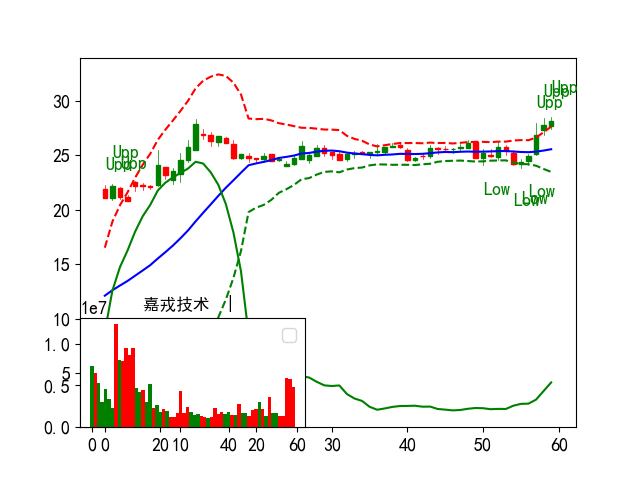

300382 1.2
xratio:-0.0 ra_diff:1.2
code: 300382


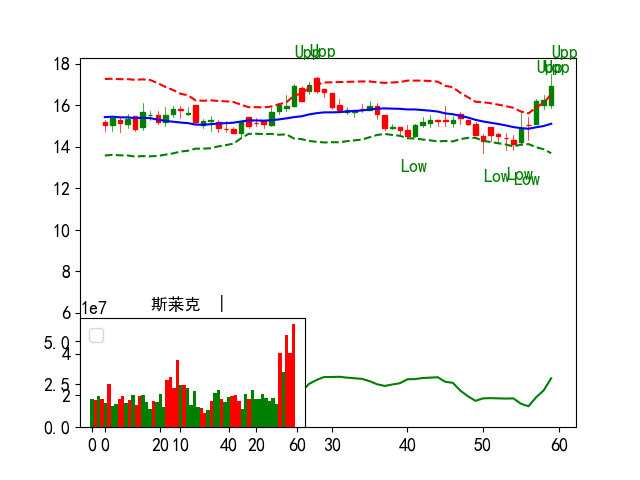

300143 1.41
xratio:0.04 ra_diff:1.41
code: 300143


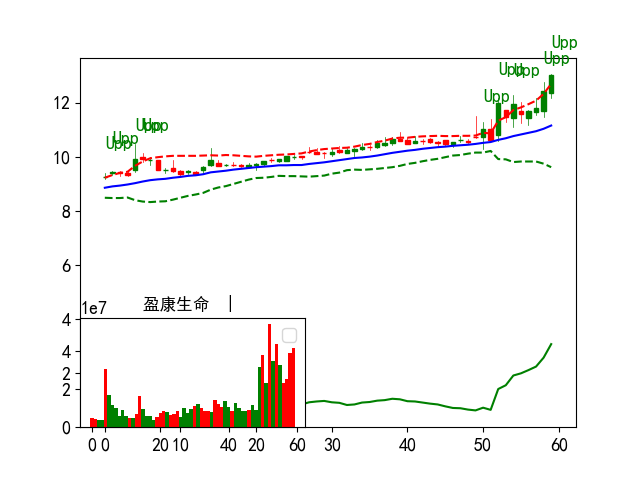

001358 1.23
xratio:0.05 ra_diff:1.23
code: 001358


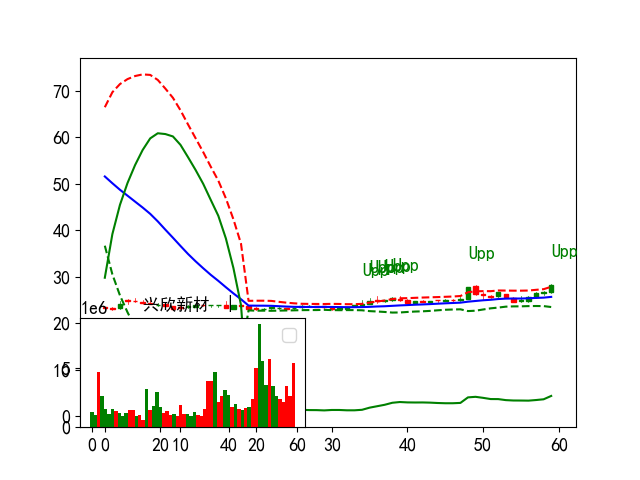

000913 1.28
xratio:0.04 ra_diff:1.28
code: 000913


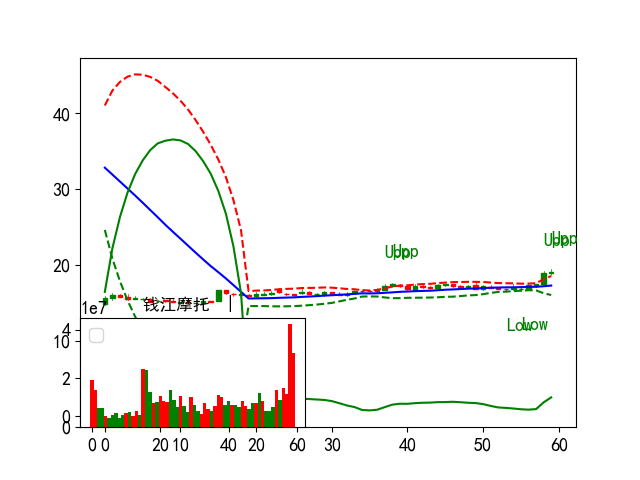

300413 1.42
xratio:0.1 ra_diff:1.42
code: 300413


603100 1.21
xratio:0.03 ra_diff:1.21
code: 603100


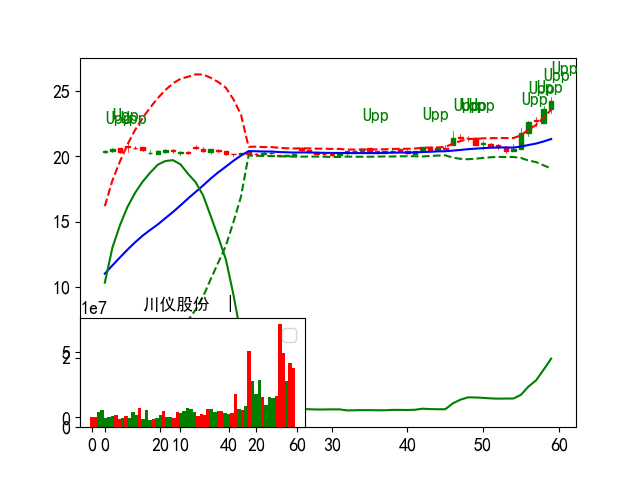

301178 1.5
xratio:0.21 ra_diff:1.5
code: 301178


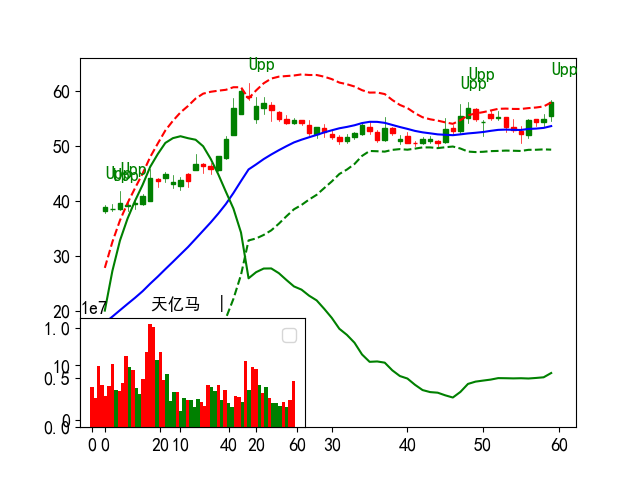

301333 1.33
xratio:0.14 ra_diff:1.33
code: 301333


603530 1.28
xratio:0.11 ra_diff:1.28
code: 603530


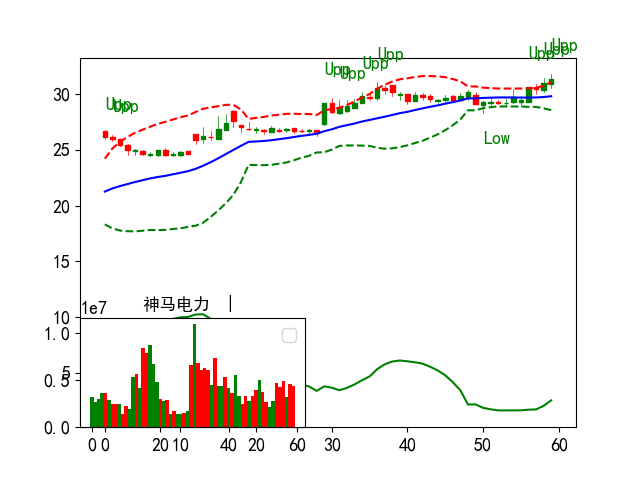

In [97]:
print("df_mask250 cross_hmax_250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [98]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()
print(len(cross_hmax_250))
# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

32


In [99]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [100]:
top_temp.shape
top_temp.index

(493, 36)

Index(['605288', '600301', '603713', '601689', '301219', '002959', '300124',
       '600673', '300953', '688348',
       ...
       '002530', '301257', '603568', '002683', '600605', '001225', '603051',
       '603666', '600814', '002318'],
      dtype='object', name='code', length=493)

## plt.close('all')

In [101]:
# plt.close('all')

# 写入060